In [40]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lightgbm as lgbm
from sklearn.metrics import log_loss
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import shutil
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import xlearn as xl
import scipy.special as special
import random

In [131]:
df2 = pd.read_csv('data/train/train2.csv')
df2 = df2[~pd.isnull(df2.is_trade)]
item_category_list_unique = list(np.unique(df2.item_category_list))
df2.item_category_list.replace(item_category_list_unique, list(np.arange(len(item_category_list_unique))), inplace=True)

In [37]:
def run(features, label, df, clf,verbose = True):
    X = df
    y = df[label]
    Loss = []
    T = X.context_timestamp <= '2018-09-23 23:59:59'
    X_train, X_test = X[T], X[~T]
    X_train, X_test = X_train[features], X_test[features]
    y_train, y_test = y[T], y[~T]
    clf.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=verbose,early_stopping_rounds=200)
    predict = clf.predict_proba(X_test)[:,1]
    logloss = log_loss(y_test, predict)
    print(logloss)
#    for i in np.linspace(0.0003, 0.0004, 1000):
#        logloss = log_loss(y_test, predict-i)
#        print('{}: {}'.format(i, logloss))
    return clf

In [30]:
df2[['item_category_list']].drop_duplicates().shape

(14, 1)

In [80]:
grouplist = ['user_gender_id','user_age_level']
#print(df2[grouplist].drop_duplicates())
df2[grouplist + ['is_trade']].groupby(grouplist).mean().reset_index()#.rename({'is_trade': '_'.join(grouplist)}, inplace = True)

,user_gender_id,user_age_level,is_trade
0,0,0,963
1,0,1000,12083
2,0,1001,5230
3,0,1002,59445
4,0,1003,135030
5,0,1004,95655
6,0,1005,40560
7,0,1006,20868
8,0,1007,3809
9,1,1000,620


In [48]:
df2.is_trade.sample(2).sum()

0.0

In [166]:
class BayesSmooth():
    def __init__(self, alpha, beta, df):
        self.alpha = alpha
        self.beta = beta
        self.df = df
        
    def sample_from_data(self, alpha, beta, num):
        I = []
        C = []
        for _ in range(num):
            imp = int(np.ceil(random.random() * self.df.shape[0]))
            I.append(imp)
            C.append(self.df.is_trade.sample(n=imp).sum())
        return I, C
    
    def update_from_data_by_FPI(self, tries, success, iter_num, epsilon):
        '''estimate alpha, beta using fixed point iteration'''
        for i in range(iter_num):
            if i%100 == 0:
                print('---{} iteration---'.format(i))
            new_alpha, new_beta = self.__fixed_point_iteration(tries, success, self.alpha, self.beta)
            if abs(new_alpha-self.alpha)<epsilon and abs(new_beta-self.beta)<epsilon:
                break
            self.alpha = new_alpha
            self.beta = new_beta
            
    def __fixed_point_iteration(self, tries, success, alpha, beta):
        '''fixed point iteration'''
        sumfenzialpha = 0.0
        sumfenzibeta = 0.0
        sumfenmu = 0.0
        for i in range(len(tries)):
            sumfenzialpha += (special.digamma(success[i]+alpha) - special.digamma(alpha))
            sumfenzibeta += (special.digamma(tries[i]-success[i]+beta) - special.digamma(beta))
            sumfenmu += (special.digamma(tries[i]+alpha+beta) - special.digamma(alpha+beta))

        return alpha*(sumfenzialpha/sumfenmu), beta*(sumfenzibeta/sumfenmu)

    def update_from_data_by_moment(self, tries, success):
        '''estimate alpha, beta using moment estimation'''
        mean, var = self.__compute_moment(tries, success)
        self.alpha = (mean+0.000001) * ((mean+0.000001) * (1.000001 - mean) / (var+0.000001) - 1)
        #self.beta = (1-mean)*(mean*(1-mean)/(var+0.000001)-1)
        self.beta = (1.000001 - mean) * ((mean+0.000001) * (1.000001 - mean) / (var+0.000001) - 1)

    def __compute_moment(self, tries, success):
        '''moment estimation'''
        ctr_list = []
        var = 0.0
        for i in range(len(tries)):
            ctr_list.append(float(success[i])/tries[i])
        mean = sum(ctr_list)/len(ctr_list)
        for ctr in ctr_list:
            var += pow(ctr-mean, 2)

        return mean, var/(len(ctr_list)-1)
    
    def export_ratio(self):
        s = self.sample_from_data(18,1000,10000)
        self.update_from_data_by_moment(s[0], s[1])
        s = self.sample_from_data(18,1000,10000)
        self.update_from_data_by_FPI(s[0], s[1], 300, 0.00000001)
            
        return (self.df.is_trade.sum() + self.alpha) / (self.df.shape[0] + self.alpha + self.beta)

In [168]:
grouplist = ['user_gender_id','user_age_level']
newconvert = []
if 1:
    for g in np.unique(df2[grouplist[0]])[:1]:
        for a in np.unique(df2[grouplist[1]])[:1]:
            testdf = df2[(df2[grouplist[0]] == g) & (df2[grouplist[1]] == a)][grouplist + ['is_trade']]
            print(testdf.shape)
            t = BayesSmooth(1,1,testdf)
            if testdf.shape[0]:
                newconvert.append([g,a,t.export_ratio()])
            else:
                newconvert.append([g,a,0])

convert = df2[grouplist + ['is_trade']].groupby(grouplist).mean().reset_index()#.rename({'is_trade': '_'.join(grouplist)}, inplace = True)
newconvert = pd.DataFrame(np.array(newconvert))
newconvert.columns = convert.columns
T = pd.merge(newconvert, convert, on = grouplist)
T.columns = [grouplist[0],grouplist[1],'{}_{}_mean_bayes'.format(grouplist[0],grouplist[1]),'{}_{}_mean_no_bayes'.format(grouplist[0],grouplist[1])]
T.to_csv('{}_{}_mean.csv'.format(grouplist[0],grouplist[1]), index = None)

(963, 3)
---0 iteration---
---100 iteration---
---200 iteration---


In [162]:
grouplist = ['user_gender_id','user_age_level']
df2[grouplist + ['is_trade']].groupby(grouplist).mean().reset_index()#.rename({'is_trade': '_'.join(grouplist)}, inplace = True)

,user_gender_id,user_age_level,is_trade
0,0.0,0.0,0.012461
1,0.0,1000.0,0.013656
2,0.0,1001.0,0.013958
3,0.0,1002.0,0.015460
4,0.0,1003.0,0.017566
5,0.0,1004.0,0.019685
6,0.0,1005.0,0.022263
7,0.0,1006.0,0.019264
8,0.0,1007.0,0.021265
9,1.0,1000.0,0.011290


In [94]:
newconvert = pd.DataFrame(newconvert)
newconvert.columns = convert.columns

,user_gender_id,user_age_level,is_trade_x,is_trade_y
0,0,0,1.288306e-02,0.012600
1,0,1000,1.338319e-02,0.013345
2,0,1001,1.358200e-02,0.013516
3,0,1002,1.540835e-02,0.015402
4,0,1003,1.816955e-02,0.018166
5,0,1004,1.998405e-02,0.019979
6,0,1005,2.240927e-02,0.022398
7,0,1006,1.918718e-02,0.019167
8,0,1007,2.144140e-02,0.021340
9,1,1000,1.113477e-02,0.010772


In [161]:
T.to_csv('user_gender_id_user_age_level_mean.csv', index = None)

In [95]:
T = pd.merge(newconvert, convert, on = grouplist)

In [159]:
T.columns = ['user_gender_id','user_age_level','user_gender_id_user_age_level_mean_bayes','user_gender_id_user_age_level_mean_no_bayes']

In [143]:
df2 = df2.merge(T, on = grouplist, how = 'left')

In [153]:
df2.user_gender_id = df2.user_gender_id.astype(float)

In [151]:
df2.user_age_level[1]

1004.0

40
[1]	training's binary_logloss: 0.648025	valid_1's binary_logloss: 0.647791
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_logloss: 0.607201	valid_1's binary_logloss: 0.606753
[3]	training's binary_logloss: 0.570105	valid_1's binary_logloss: 0.569448
[4]	training's binary_logloss: 0.536266	valid_1's binary_logloss: 0.535405
[5]	training's binary_logloss: 0.505299	valid_1's binary_logloss: 0.504246
[6]	training's binary_logloss: 0.476876	valid_1's binary_logloss: 0.475636
[7]	training's binary_logloss: 0.45072	valid_1's binary_logloss: 0.449296
[8]	training's binary_logloss: 0.426599	valid_1's binary_logloss: 0.425005
[9]	training's binary_logloss: 0.404308	valid_1's binary_logloss: 0.402548
[10]	training's binary_logloss: 0.383672	valid_1's binary_logloss: 0.381754
[11]	training's binary_logloss: 0.364536	valid_1's binary_logloss: 0.362466
[12]	training's binary_logloss: 0.346768	valid_1's binary_logloss: 0.344548
[13]	training's binary_logloss: 

[112]	training's binary_logloss: 0.089391	valid_1's binary_logloss: 0.0815113
[113]	training's binary_logloss: 0.0893466	valid_1's binary_logloss: 0.081465
[114]	training's binary_logloss: 0.0893085	valid_1's binary_logloss: 0.0814249
[115]	training's binary_logloss: 0.0892688	valid_1's binary_logloss: 0.0813648
[116]	training's binary_logloss: 0.0892265	valid_1's binary_logloss: 0.0813231
[117]	training's binary_logloss: 0.0891836	valid_1's binary_logloss: 0.0812815
[118]	training's binary_logloss: 0.0891449	valid_1's binary_logloss: 0.0812437
[119]	training's binary_logloss: 0.0891124	valid_1's binary_logloss: 0.0812163
[120]	training's binary_logloss: 0.0890722	valid_1's binary_logloss: 0.0811734
[121]	training's binary_logloss: 0.0890363	valid_1's binary_logloss: 0.0811352
[122]	training's binary_logloss: 0.0889967	valid_1's binary_logloss: 0.0811011
[123]	training's binary_logloss: 0.088964	valid_1's binary_logloss: 0.0810697
[124]	training's binary_logloss: 0.0889317	valid_1's bi

[217]	training's binary_logloss: 0.0872844	valid_1's binary_logloss: 0.0798449
[218]	training's binary_logloss: 0.0872745	valid_1's binary_logloss: 0.0798426
[219]	training's binary_logloss: 0.0872668	valid_1's binary_logloss: 0.0798352
[220]	training's binary_logloss: 0.0872561	valid_1's binary_logloss: 0.0798229
[221]	training's binary_logloss: 0.0872463	valid_1's binary_logloss: 0.0798199
[222]	training's binary_logloss: 0.0872328	valid_1's binary_logloss: 0.0798111
[223]	training's binary_logloss: 0.0872238	valid_1's binary_logloss: 0.0798098
[224]	training's binary_logloss: 0.0872164	valid_1's binary_logloss: 0.0798095
[225]	training's binary_logloss: 0.0872053	valid_1's binary_logloss: 0.0798012
[226]	training's binary_logloss: 0.0871978	valid_1's binary_logloss: 0.0797987
[227]	training's binary_logloss: 0.0871904	valid_1's binary_logloss: 0.0797995
[228]	training's binary_logloss: 0.08718	valid_1's binary_logloss: 0.0797932
[229]	training's binary_logloss: 0.0871717	valid_1's b

[321]	training's binary_logloss: 0.0865224	valid_1's binary_logloss: 0.0794561
[322]	training's binary_logloss: 0.0865163	valid_1's binary_logloss: 0.0794531
[323]	training's binary_logloss: 0.0865095	valid_1's binary_logloss: 0.0794512
[324]	training's binary_logloss: 0.0865038	valid_1's binary_logloss: 0.0794476
[325]	training's binary_logloss: 0.0864993	valid_1's binary_logloss: 0.0794459
[326]	training's binary_logloss: 0.0864932	valid_1's binary_logloss: 0.0794413
[327]	training's binary_logloss: 0.086489	valid_1's binary_logloss: 0.0794384
[328]	training's binary_logloss: 0.0864834	valid_1's binary_logloss: 0.0794372
[329]	training's binary_logloss: 0.0864779	valid_1's binary_logloss: 0.0794388
[330]	training's binary_logloss: 0.0864731	valid_1's binary_logloss: 0.0794375
[331]	training's binary_logloss: 0.0864659	valid_1's binary_logloss: 0.0794368
[332]	training's binary_logloss: 0.0864609	valid_1's binary_logloss: 0.0794338
[333]	training's binary_logloss: 0.0864566	valid_1's 

[431]	training's binary_logloss: 0.086017	valid_1's binary_logloss: 0.0792508
[432]	training's binary_logloss: 0.0860125	valid_1's binary_logloss: 0.0792524
[433]	training's binary_logloss: 0.0860078	valid_1's binary_logloss: 0.07925
[434]	training's binary_logloss: 0.086003	valid_1's binary_logloss: 0.0792495
[435]	training's binary_logloss: 0.0859991	valid_1's binary_logloss: 0.0792495
[436]	training's binary_logloss: 0.0859955	valid_1's binary_logloss: 0.0792484
[437]	training's binary_logloss: 0.0859906	valid_1's binary_logloss: 0.079247
[438]	training's binary_logloss: 0.0859867	valid_1's binary_logloss: 0.0792503
[439]	training's binary_logloss: 0.0859819	valid_1's binary_logloss: 0.0792469
[440]	training's binary_logloss: 0.0859775	valid_1's binary_logloss: 0.0792475
[441]	training's binary_logloss: 0.0859733	valid_1's binary_logloss: 0.0792476
[442]	training's binary_logloss: 0.0859695	valid_1's binary_logloss: 0.0792435
[443]	training's binary_logloss: 0.0859656	valid_1's bina

[540]	training's binary_logloss: 0.08561	valid_1's binary_logloss: 0.0791191
[541]	training's binary_logloss: 0.0856056	valid_1's binary_logloss: 0.0791173
[542]	training's binary_logloss: 0.0856022	valid_1's binary_logloss: 0.0791152
[543]	training's binary_logloss: 0.0855998	valid_1's binary_logloss: 0.0791138
[544]	training's binary_logloss: 0.0855953	valid_1's binary_logloss: 0.0791103
[545]	training's binary_logloss: 0.0855926	valid_1's binary_logloss: 0.0791117
[546]	training's binary_logloss: 0.0855887	valid_1's binary_logloss: 0.0791116
[547]	training's binary_logloss: 0.0855851	valid_1's binary_logloss: 0.0791103
[548]	training's binary_logloss: 0.0855813	valid_1's binary_logloss: 0.0791109
[549]	training's binary_logloss: 0.0855769	valid_1's binary_logloss: 0.0791091
[550]	training's binary_logloss: 0.0855738	valid_1's binary_logloss: 0.0791091
[551]	training's binary_logloss: 0.0855702	valid_1's binary_logloss: 0.0791084
[552]	training's binary_logloss: 0.0855669	valid_1's b

[648]	training's binary_logloss: 0.0852771	valid_1's binary_logloss: 0.079021
[649]	training's binary_logloss: 0.0852737	valid_1's binary_logloss: 0.07902
[650]	training's binary_logloss: 0.0852717	valid_1's binary_logloss: 0.0790179
[651]	training's binary_logloss: 0.0852686	valid_1's binary_logloss: 0.0790157
[652]	training's binary_logloss: 0.0852656	valid_1's binary_logloss: 0.0790142
[653]	training's binary_logloss: 0.0852621	valid_1's binary_logloss: 0.0790125
[654]	training's binary_logloss: 0.0852603	valid_1's binary_logloss: 0.0790136
[655]	training's binary_logloss: 0.0852572	valid_1's binary_logloss: 0.0790129
[656]	training's binary_logloss: 0.0852538	valid_1's binary_logloss: 0.0790111
[657]	training's binary_logloss: 0.0852532	valid_1's binary_logloss: 0.079011
[658]	training's binary_logloss: 0.0852498	valid_1's binary_logloss: 0.0790091
[659]	training's binary_logloss: 0.0852472	valid_1's binary_logloss: 0.0790127
[660]	training's binary_logloss: 0.0852448	valid_1's bin

[757]	training's binary_logloss: 0.0849714	valid_1's binary_logloss: 0.0789362
[758]	training's binary_logloss: 0.0849668	valid_1's binary_logloss: 0.0789362
[759]	training's binary_logloss: 0.0849636	valid_1's binary_logloss: 0.0789332
[760]	training's binary_logloss: 0.0849621	valid_1's binary_logloss: 0.0789343
[761]	training's binary_logloss: 0.0849602	valid_1's binary_logloss: 0.0789345
[762]	training's binary_logloss: 0.0849573	valid_1's binary_logloss: 0.0789343
[763]	training's binary_logloss: 0.0849562	valid_1's binary_logloss: 0.0789328
[764]	training's binary_logloss: 0.084955	valid_1's binary_logloss: 0.0789299
[765]	training's binary_logloss: 0.0849518	valid_1's binary_logloss: 0.0789301
[766]	training's binary_logloss: 0.084951	valid_1's binary_logloss: 0.0789297
[767]	training's binary_logloss: 0.0849489	valid_1's binary_logloss: 0.0789306
[768]	training's binary_logloss: 0.0849465	valid_1's binary_logloss: 0.0789276
[769]	training's binary_logloss: 0.0849449	valid_1's b

[868]	training's binary_logloss: 0.0846811	valid_1's binary_logloss: 0.078887
[869]	training's binary_logloss: 0.0846766	valid_1's binary_logloss: 0.0788871
[870]	training's binary_logloss: 0.0846746	valid_1's binary_logloss: 0.0788885
[871]	training's binary_logloss: 0.0846716	valid_1's binary_logloss: 0.0788891
[872]	training's binary_logloss: 0.0846699	valid_1's binary_logloss: 0.0788906
[873]	training's binary_logloss: 0.0846669	valid_1's binary_logloss: 0.0788896
[874]	training's binary_logloss: 0.0846639	valid_1's binary_logloss: 0.0788902
[875]	training's binary_logloss: 0.0846592	valid_1's binary_logloss: 0.078887
[876]	training's binary_logloss: 0.0846574	valid_1's binary_logloss: 0.0788872
[877]	training's binary_logloss: 0.0846549	valid_1's binary_logloss: 0.0788878
[878]	training's binary_logloss: 0.0846523	valid_1's binary_logloss: 0.0788854
[879]	training's binary_logloss: 0.0846502	valid_1's binary_logloss: 0.0788851
[880]	training's binary_logloss: 0.0846481	valid_1's b

[975]	training's binary_logloss: 0.0844228	valid_1's binary_logloss: 0.0788573
[976]	training's binary_logloss: 0.0844197	valid_1's binary_logloss: 0.0788578
[977]	training's binary_logloss: 0.0844172	valid_1's binary_logloss: 0.0788578
[978]	training's binary_logloss: 0.0844141	valid_1's binary_logloss: 0.0788553
[979]	training's binary_logloss: 0.0844116	valid_1's binary_logloss: 0.0788556
[980]	training's binary_logloss: 0.0844071	valid_1's binary_logloss: 0.078854
[981]	training's binary_logloss: 0.0844039	valid_1's binary_logloss: 0.0788534
[982]	training's binary_logloss: 0.0844021	valid_1's binary_logloss: 0.0788543
[983]	training's binary_logloss: 0.0844007	valid_1's binary_logloss: 0.0788545
[984]	training's binary_logloss: 0.0843982	valid_1's binary_logloss: 0.0788544
[985]	training's binary_logloss: 0.0843953	valid_1's binary_logloss: 0.0788548
[986]	training's binary_logloss: 0.0843945	valid_1's binary_logloss: 0.0788552
[987]	training's binary_logloss: 0.0843928	valid_1's 

[1080]	training's binary_logloss: 0.0841681	valid_1's binary_logloss: 0.0788325
[1081]	training's binary_logloss: 0.0841657	valid_1's binary_logloss: 0.0788321
[1082]	training's binary_logloss: 0.0841634	valid_1's binary_logloss: 0.0788303
[1083]	training's binary_logloss: 0.0841615	valid_1's binary_logloss: 0.0788315
[1084]	training's binary_logloss: 0.0841593	valid_1's binary_logloss: 0.0788329
[1085]	training's binary_logloss: 0.0841571	valid_1's binary_logloss: 0.0788322
[1086]	training's binary_logloss: 0.0841545	valid_1's binary_logloss: 0.0788302
[1087]	training's binary_logloss: 0.0841526	valid_1's binary_logloss: 0.0788263
[1088]	training's binary_logloss: 0.0841499	valid_1's binary_logloss: 0.0788266
[1089]	training's binary_logloss: 0.0841492	valid_1's binary_logloss: 0.0788268
[1090]	training's binary_logloss: 0.084146	valid_1's binary_logloss: 0.0788256
[1091]	training's binary_logloss: 0.084144	valid_1's binary_logloss: 0.0788252
[1092]	training's binary_logloss: 0.084142

[1183]	training's binary_logloss: 0.0839357	valid_1's binary_logloss: 0.0787915
[1184]	training's binary_logloss: 0.0839333	valid_1's binary_logloss: 0.0787907
[1185]	training's binary_logloss: 0.0839311	valid_1's binary_logloss: 0.0787908
[1186]	training's binary_logloss: 0.0839278	valid_1's binary_logloss: 0.0787913
[1187]	training's binary_logloss: 0.0839247	valid_1's binary_logloss: 0.0787907
[1188]	training's binary_logloss: 0.0839236	valid_1's binary_logloss: 0.0787916
[1189]	training's binary_logloss: 0.0839216	valid_1's binary_logloss: 0.0787921
[1190]	training's binary_logloss: 0.08392	valid_1's binary_logloss: 0.0787936
[1191]	training's binary_logloss: 0.0839192	valid_1's binary_logloss: 0.0787923
[1192]	training's binary_logloss: 0.083919	valid_1's binary_logloss: 0.0787921
[1193]	training's binary_logloss: 0.0839166	valid_1's binary_logloss: 0.0787916
[1194]	training's binary_logloss: 0.0839133	valid_1's binary_logloss: 0.07879
[1195]	training's binary_logloss: 0.0839114	v

[1290]	training's binary_logloss: 0.0837087	valid_1's binary_logloss: 0.0787593
[1291]	training's binary_logloss: 0.0837064	valid_1's binary_logloss: 0.0787605
[1292]	training's binary_logloss: 0.0837045	valid_1's binary_logloss: 0.0787606
[1293]	training's binary_logloss: 0.0837033	valid_1's binary_logloss: 0.0787607
[1294]	training's binary_logloss: 0.0837003	valid_1's binary_logloss: 0.0787614
[1295]	training's binary_logloss: 0.0836984	valid_1's binary_logloss: 0.078761
[1296]	training's binary_logloss: 0.0836973	valid_1's binary_logloss: 0.0787598
[1297]	training's binary_logloss: 0.0836948	valid_1's binary_logloss: 0.0787591
[1298]	training's binary_logloss: 0.0836927	valid_1's binary_logloss: 0.0787582
[1299]	training's binary_logloss: 0.0836906	valid_1's binary_logloss: 0.0787567
[1300]	training's binary_logloss: 0.0836886	valid_1's binary_logloss: 0.0787577
[1301]	training's binary_logloss: 0.0836869	valid_1's binary_logloss: 0.0787578
[1302]	training's binary_logloss: 0.08368

[1399]	training's binary_logloss: 0.0834909	valid_1's binary_logloss: 0.0787178
[1400]	training's binary_logloss: 0.0834884	valid_1's binary_logloss: 0.0787159
[1401]	training's binary_logloss: 0.0834858	valid_1's binary_logloss: 0.0787145
[1402]	training's binary_logloss: 0.0834835	valid_1's binary_logloss: 0.0787168
[1403]	training's binary_logloss: 0.083482	valid_1's binary_logloss: 0.0787169
[1404]	training's binary_logloss: 0.0834806	valid_1's binary_logloss: 0.0787159
[1405]	training's binary_logloss: 0.0834787	valid_1's binary_logloss: 0.0787175
[1406]	training's binary_logloss: 0.0834755	valid_1's binary_logloss: 0.0787191
[1407]	training's binary_logloss: 0.0834725	valid_1's binary_logloss: 0.0787204
[1408]	training's binary_logloss: 0.0834702	valid_1's binary_logloss: 0.0787198
[1409]	training's binary_logloss: 0.0834668	valid_1's binary_logloss: 0.0787208
[1410]	training's binary_logloss: 0.0834648	valid_1's binary_logloss: 0.0787188
[1411]	training's binary_logloss: 0.08346

[1502]	training's binary_logloss: 0.0832894	valid_1's binary_logloss: 0.0787127
[1503]	training's binary_logloss: 0.0832867	valid_1's binary_logloss: 0.0787135
[1504]	training's binary_logloss: 0.0832836	valid_1's binary_logloss: 0.0787146
[1505]	training's binary_logloss: 0.0832815	valid_1's binary_logloss: 0.0787164
[1506]	training's binary_logloss: 0.0832802	valid_1's binary_logloss: 0.0787175
[1507]	training's binary_logloss: 0.0832786	valid_1's binary_logloss: 0.0787177
[1508]	training's binary_logloss: 0.0832766	valid_1's binary_logloss: 0.0787166
[1509]	training's binary_logloss: 0.0832744	valid_1's binary_logloss: 0.078718
[1510]	training's binary_logloss: 0.0832723	valid_1's binary_logloss: 0.0787162
[1511]	training's binary_logloss: 0.0832701	valid_1's binary_logloss: 0.078718
[1512]	training's binary_logloss: 0.0832682	valid_1's binary_logloss: 0.0787172
[1513]	training's binary_logloss: 0.0832662	valid_1's binary_logloss: 0.0787189
[1514]	training's binary_logloss: 0.083262

[1605]	training's binary_logloss: 0.0830792	valid_1's binary_logloss: 0.0786913
[1606]	training's binary_logloss: 0.083077	valid_1's binary_logloss: 0.0786918
[1607]	training's binary_logloss: 0.0830757	valid_1's binary_logloss: 0.078692
[1608]	training's binary_logloss: 0.083073	valid_1's binary_logloss: 0.0786932
[1609]	training's binary_logloss: 0.0830722	valid_1's binary_logloss: 0.0786937
[1610]	training's binary_logloss: 0.0830718	valid_1's binary_logloss: 0.0786941
[1611]	training's binary_logloss: 0.0830697	valid_1's binary_logloss: 0.0786911
[1612]	training's binary_logloss: 0.0830675	valid_1's binary_logloss: 0.0786922
[1613]	training's binary_logloss: 0.0830655	valid_1's binary_logloss: 0.0786944
[1614]	training's binary_logloss: 0.0830639	valid_1's binary_logloss: 0.0786966
[1615]	training's binary_logloss: 0.0830622	valid_1's binary_logloss: 0.0786954
[1616]	training's binary_logloss: 0.0830599	valid_1's binary_logloss: 0.0786964
[1617]	training's binary_logloss: 0.0830569

[1709]	training's binary_logloss: 0.0828841	valid_1's binary_logloss: 0.0786921
[1710]	training's binary_logloss: 0.0828826	valid_1's binary_logloss: 0.0786924
[1711]	training's binary_logloss: 0.0828805	valid_1's binary_logloss: 0.0786912
[1712]	training's binary_logloss: 0.0828787	valid_1's binary_logloss: 0.0786931
[1713]	training's binary_logloss: 0.0828776	valid_1's binary_logloss: 0.0786921
[1714]	training's binary_logloss: 0.0828752	valid_1's binary_logloss: 0.0786912
[1715]	training's binary_logloss: 0.0828734	valid_1's binary_logloss: 0.0786917
[1716]	training's binary_logloss: 0.082871	valid_1's binary_logloss: 0.078692
[1717]	training's binary_logloss: 0.0828685	valid_1's binary_logloss: 0.078693
[1718]	training's binary_logloss: 0.0828664	valid_1's binary_logloss: 0.0786948
[1719]	training's binary_logloss: 0.0828646	valid_1's binary_logloss: 0.078695
[1720]	training's binary_logloss: 0.0828622	valid_1's binary_logloss: 0.078697
[1721]	training's binary_logloss: 0.0828603	v

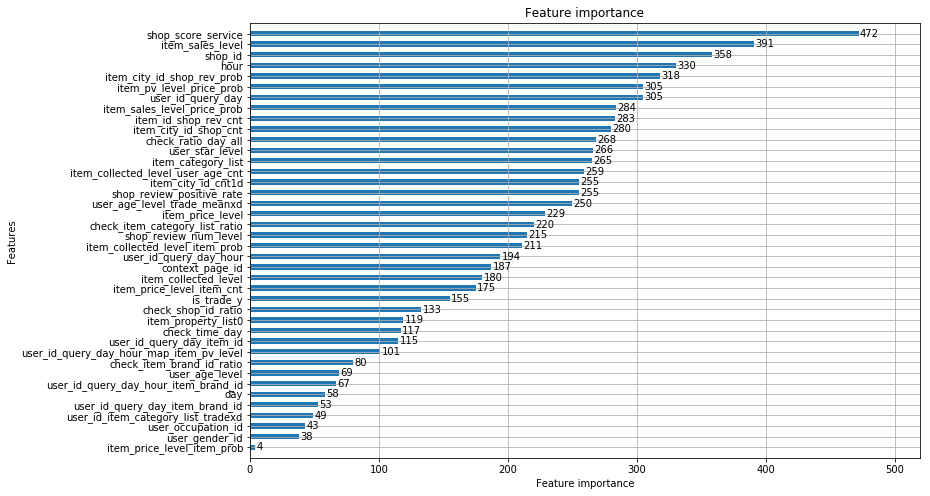

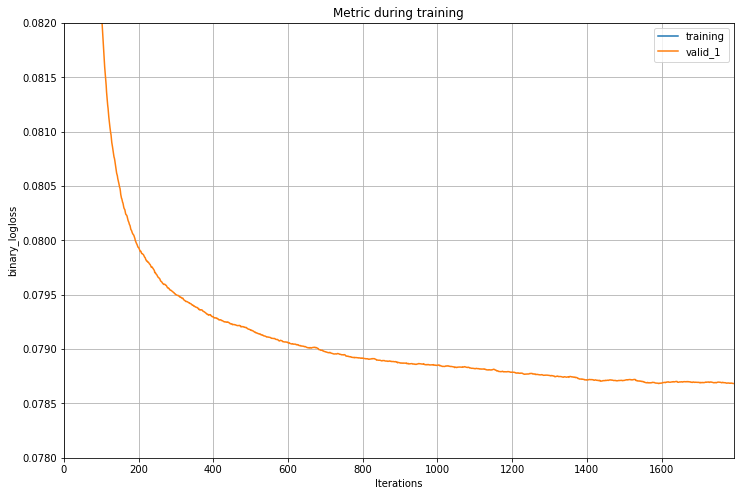

In [158]:
label = 'is_trade'
start_features = ['is_trade_y','item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'item_price_level_item_cnt', 'item_price_level_item_prob', 'user_age_level_trade_meanxd', 'user_id_item_category_list_tradexd','user_occupation_id', 'user_id_query_day_hour_map_item_pv_level', 'check_time_day', 'shop_review_num_level']
print(len(start_features))
clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=5000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=8)

clf = run(start_features, label, df2, clf, True)
lgbm.plot_importance(clf,figsize=(12,8),height=0.5)
plt.show()
lgbm.plot_metric(clf,figsize=(12,8),ylim=(0.078,0.082))
plt.show()

In [118]:
for i in df2.user_age_level:
    if isinstance(i, int):
        pass
    else:
        print(type(i))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

KeyboardInterrupt: 

In [123]:
print(isinstance(df2.user_star_level.values[0], int))
print(type(df2.user_star_level.values[0]))

False
<class 'numpy.int64'>


35
hour_map
[1]	training's binary_logloss: 0.648025	valid_1's binary_logloss: 0.647791
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_logloss: 0.607201	valid_1's binary_logloss: 0.606748
[3]	training's binary_logloss: 0.570105	valid_1's binary_logloss: 0.569443
[4]	training's binary_logloss: 0.536266	valid_1's binary_logloss: 0.535403
[5]	training's binary_logloss: 0.505299	valid_1's binary_logloss: 0.504244
[6]	training's binary_logloss: 0.476876	valid_1's binary_logloss: 0.475636
[7]	training's binary_logloss: 0.45072	valid_1's binary_logloss: 0.449295
[8]	training's binary_logloss: 0.426598	valid_1's binary_logloss: 0.425005
[9]	training's binary_logloss: 0.404308	valid_1's binary_logloss: 0.40255
[10]	training's binary_logloss: 0.383672	valid_1's binary_logloss: 0.381755
[11]	training's binary_logloss: 0.364535	valid_1's binary_logloss: 0.362469
[12]	training's binary_logloss: 0.346767	valid_1's binary_logloss: 0.34455
[13]	training's binary_lo

[107]	training's binary_logloss: 0.0896129	valid_1's binary_logloss: 0.0818046
[108]	training's binary_logloss: 0.0895688	valid_1's binary_logloss: 0.0817543
[109]	training's binary_logloss: 0.0895103	valid_1's binary_logloss: 0.0816968
[110]	training's binary_logloss: 0.0894687	valid_1's binary_logloss: 0.081647
[111]	training's binary_logloss: 0.0894221	valid_1's binary_logloss: 0.0815955
[112]	training's binary_logloss: 0.0893802	valid_1's binary_logloss: 0.0815605
[113]	training's binary_logloss: 0.0893303	valid_1's binary_logloss: 0.08151
[114]	training's binary_logloss: 0.0892906	valid_1's binary_logloss: 0.0814697
[115]	training's binary_logloss: 0.0892554	valid_1's binary_logloss: 0.0814318
[116]	training's binary_logloss: 0.0892146	valid_1's binary_logloss: 0.0814014
[117]	training's binary_logloss: 0.089166	valid_1's binary_logloss: 0.0813602
[118]	training's binary_logloss: 0.0891222	valid_1's binary_logloss: 0.0813177
[119]	training's binary_logloss: 0.0890883	valid_1's bin

[212]	training's binary_logloss: 0.0873677	valid_1's binary_logloss: 0.0799658
[213]	training's binary_logloss: 0.0873576	valid_1's binary_logloss: 0.0799608
[214]	training's binary_logloss: 0.0873499	valid_1's binary_logloss: 0.0799563
[215]	training's binary_logloss: 0.0873395	valid_1's binary_logloss: 0.0799436
[216]	training's binary_logloss: 0.0873318	valid_1's binary_logloss: 0.0799381
[217]	training's binary_logloss: 0.0873241	valid_1's binary_logloss: 0.0799406
[218]	training's binary_logloss: 0.0873145	valid_1's binary_logloss: 0.0799367
[219]	training's binary_logloss: 0.0873029	valid_1's binary_logloss: 0.079933
[220]	training's binary_logloss: 0.0872933	valid_1's binary_logloss: 0.0799307
[221]	training's binary_logloss: 0.0872811	valid_1's binary_logloss: 0.0799283
[222]	training's binary_logloss: 0.0872725	valid_1's binary_logloss: 0.0799254
[223]	training's binary_logloss: 0.0872652	valid_1's binary_logloss: 0.0799226
[224]	training's binary_logloss: 0.0872561	valid_1's 

[317]	training's binary_logloss: 0.0866081	valid_1's binary_logloss: 0.0795908
[318]	training's binary_logloss: 0.0866013	valid_1's binary_logloss: 0.0795848
[319]	training's binary_logloss: 0.0865974	valid_1's binary_logloss: 0.0795844
[320]	training's binary_logloss: 0.0865925	valid_1's binary_logloss: 0.0795843
[321]	training's binary_logloss: 0.0865884	valid_1's binary_logloss: 0.0795824
[322]	training's binary_logloss: 0.0865837	valid_1's binary_logloss: 0.079577
[323]	training's binary_logloss: 0.0865796	valid_1's binary_logloss: 0.0795719
[324]	training's binary_logloss: 0.0865733	valid_1's binary_logloss: 0.0795682
[325]	training's binary_logloss: 0.0865676	valid_1's binary_logloss: 0.0795675
[326]	training's binary_logloss: 0.0865627	valid_1's binary_logloss: 0.0795695
[327]	training's binary_logloss: 0.0865559	valid_1's binary_logloss: 0.0795659
[328]	training's binary_logloss: 0.0865478	valid_1's binary_logloss: 0.079561
[329]	training's binary_logloss: 0.0865426	valid_1's b

[422]	training's binary_logloss: 0.0861233	valid_1's binary_logloss: 0.0794004
[423]	training's binary_logloss: 0.0861199	valid_1's binary_logloss: 0.0793964
[424]	training's binary_logloss: 0.0861169	valid_1's binary_logloss: 0.0793962
[425]	training's binary_logloss: 0.086112	valid_1's binary_logloss: 0.0793939
[426]	training's binary_logloss: 0.0861051	valid_1's binary_logloss: 0.0793934
[427]	training's binary_logloss: 0.0861	valid_1's binary_logloss: 0.0793931
[428]	training's binary_logloss: 0.0860972	valid_1's binary_logloss: 0.0793917
[429]	training's binary_logloss: 0.0860926	valid_1's binary_logloss: 0.0793909
[430]	training's binary_logloss: 0.0860883	valid_1's binary_logloss: 0.0793921
[431]	training's binary_logloss: 0.086086	valid_1's binary_logloss: 0.0793922
[432]	training's binary_logloss: 0.0860792	valid_1's binary_logloss: 0.0793928
[433]	training's binary_logloss: 0.0860768	valid_1's binary_logloss: 0.0793918
[434]	training's binary_logloss: 0.0860729	valid_1's bina

[527]	training's binary_logloss: 0.0857323	valid_1's binary_logloss: 0.0792793
[528]	training's binary_logloss: 0.0857286	valid_1's binary_logloss: 0.07928
[529]	training's binary_logloss: 0.0857264	valid_1's binary_logloss: 0.0792801
[530]	training's binary_logloss: 0.0857225	valid_1's binary_logloss: 0.0792757
[531]	training's binary_logloss: 0.0857187	valid_1's binary_logloss: 0.0792769
[532]	training's binary_logloss: 0.0857136	valid_1's binary_logloss: 0.0792759
[533]	training's binary_logloss: 0.0857105	valid_1's binary_logloss: 0.0792769
[534]	training's binary_logloss: 0.085706	valid_1's binary_logloss: 0.0792774
[535]	training's binary_logloss: 0.0857017	valid_1's binary_logloss: 0.0792781
[536]	training's binary_logloss: 0.0856996	valid_1's binary_logloss: 0.0792764
[537]	training's binary_logloss: 0.0856957	valid_1's binary_logloss: 0.0792769
[538]	training's binary_logloss: 0.0856938	valid_1's binary_logloss: 0.0792744
[539]	training's binary_logloss: 0.0856898	valid_1's bi

[632]	training's binary_logloss: 0.0854004	valid_1's binary_logloss: 0.079203
[633]	training's binary_logloss: 0.0853989	valid_1's binary_logloss: 0.0792022
[634]	training's binary_logloss: 0.0853956	valid_1's binary_logloss: 0.0791985
[635]	training's binary_logloss: 0.0853936	valid_1's binary_logloss: 0.0791982
[636]	training's binary_logloss: 0.0853903	valid_1's binary_logloss: 0.079196
[637]	training's binary_logloss: 0.0853868	valid_1's binary_logloss: 0.0791917
[638]	training's binary_logloss: 0.0853824	valid_1's binary_logloss: 0.079192
[639]	training's binary_logloss: 0.0853785	valid_1's binary_logloss: 0.0791898
[640]	training's binary_logloss: 0.0853767	valid_1's binary_logloss: 0.0791917
[641]	training's binary_logloss: 0.0853737	valid_1's binary_logloss: 0.0791904
[642]	training's binary_logloss: 0.0853715	valid_1's binary_logloss: 0.0791928
[643]	training's binary_logloss: 0.0853709	valid_1's binary_logloss: 0.0791919
[644]	training's binary_logloss: 0.0853694	valid_1's bi

[736]	training's binary_logloss: 0.0851222	valid_1's binary_logloss: 0.0791261
[737]	training's binary_logloss: 0.0851196	valid_1's binary_logloss: 0.0791207
[738]	training's binary_logloss: 0.0851174	valid_1's binary_logloss: 0.0791183
[739]	training's binary_logloss: 0.0851151	valid_1's binary_logloss: 0.0791205
[740]	training's binary_logloss: 0.085112	valid_1's binary_logloss: 0.079122
[741]	training's binary_logloss: 0.0851096	valid_1's binary_logloss: 0.0791212
[742]	training's binary_logloss: 0.0851078	valid_1's binary_logloss: 0.0791211
[743]	training's binary_logloss: 0.0851057	valid_1's binary_logloss: 0.0791212
[744]	training's binary_logloss: 0.0851033	valid_1's binary_logloss: 0.0791193
[745]	training's binary_logloss: 0.0851019	valid_1's binary_logloss: 0.0791208
[746]	training's binary_logloss: 0.0850992	valid_1's binary_logloss: 0.0791207
[747]	training's binary_logloss: 0.0850977	valid_1's binary_logloss: 0.0791216
[748]	training's binary_logloss: 0.0850961	valid_1's b

[840]	training's binary_logloss: 0.0848803	valid_1's binary_logloss: 0.0790735
[841]	training's binary_logloss: 0.0848782	valid_1's binary_logloss: 0.0790752
[842]	training's binary_logloss: 0.0848762	valid_1's binary_logloss: 0.0790749
[843]	training's binary_logloss: 0.0848728	valid_1's binary_logloss: 0.0790712
[844]	training's binary_logloss: 0.0848701	valid_1's binary_logloss: 0.0790695
[845]	training's binary_logloss: 0.0848678	valid_1's binary_logloss: 0.0790696
[846]	training's binary_logloss: 0.0848655	valid_1's binary_logloss: 0.0790689
[847]	training's binary_logloss: 0.0848626	valid_1's binary_logloss: 0.0790695
[848]	training's binary_logloss: 0.084859	valid_1's binary_logloss: 0.0790671
[849]	training's binary_logloss: 0.0848573	valid_1's binary_logloss: 0.0790665
[850]	training's binary_logloss: 0.0848533	valid_1's binary_logloss: 0.0790616
[851]	training's binary_logloss: 0.0848505	valid_1's binary_logloss: 0.0790614
[852]	training's binary_logloss: 0.0848477	valid_1's 

[944]	training's binary_logloss: 0.0846389	valid_1's binary_logloss: 0.0790623
[945]	training's binary_logloss: 0.0846382	valid_1's binary_logloss: 0.0790629
[946]	training's binary_logloss: 0.0846376	valid_1's binary_logloss: 0.079062
[947]	training's binary_logloss: 0.0846355	valid_1's binary_logloss: 0.0790625
[948]	training's binary_logloss: 0.084633	valid_1's binary_logloss: 0.079062
[949]	training's binary_logloss: 0.0846319	valid_1's binary_logloss: 0.0790642
[950]	training's binary_logloss: 0.084629	valid_1's binary_logloss: 0.079061
[951]	training's binary_logloss: 0.0846272	valid_1's binary_logloss: 0.07906
[952]	training's binary_logloss: 0.0846251	valid_1's binary_logloss: 0.0790561
[953]	training's binary_logloss: 0.0846229	valid_1's binary_logloss: 0.0790563
[954]	training's binary_logloss: 0.0846212	valid_1's binary_logloss: 0.0790532
[955]	training's binary_logloss: 0.0846197	valid_1's binary_logloss: 0.0790532
[956]	training's binary_logloss: 0.0846159	valid_1's binary

[1050]	training's binary_logloss: 0.0844157	valid_1's binary_logloss: 0.0790394
[1051]	training's binary_logloss: 0.0844129	valid_1's binary_logloss: 0.0790389
[1052]	training's binary_logloss: 0.0844105	valid_1's binary_logloss: 0.0790389
[1053]	training's binary_logloss: 0.0844086	valid_1's binary_logloss: 0.0790394
[1054]	training's binary_logloss: 0.0844035	valid_1's binary_logloss: 0.0790381
[1055]	training's binary_logloss: 0.0844002	valid_1's binary_logloss: 0.0790371
[1056]	training's binary_logloss: 0.0843966	valid_1's binary_logloss: 0.0790346
[1057]	training's binary_logloss: 0.0843946	valid_1's binary_logloss: 0.0790335
[1058]	training's binary_logloss: 0.0843927	valid_1's binary_logloss: 0.0790333
[1059]	training's binary_logloss: 0.0843907	valid_1's binary_logloss: 0.0790319
[1060]	training's binary_logloss: 0.0843898	valid_1's binary_logloss: 0.0790315
[1061]	training's binary_logloss: 0.0843878	valid_1's binary_logloss: 0.0790305
[1062]	training's binary_logloss: 0.0843

[1153]	training's binary_logloss: 0.0841911	valid_1's binary_logloss: 0.0790325
[1154]	training's binary_logloss: 0.0841903	valid_1's binary_logloss: 0.0790332
[1155]	training's binary_logloss: 0.0841883	valid_1's binary_logloss: 0.0790333
[1156]	training's binary_logloss: 0.0841879	valid_1's binary_logloss: 0.0790327
[1157]	training's binary_logloss: 0.0841854	valid_1's binary_logloss: 0.0790334
[1158]	training's binary_logloss: 0.0841841	valid_1's binary_logloss: 0.0790303
[1159]	training's binary_logloss: 0.0841824	valid_1's binary_logloss: 0.0790287
[1160]	training's binary_logloss: 0.0841804	valid_1's binary_logloss: 0.079029
[1161]	training's binary_logloss: 0.0841789	valid_1's binary_logloss: 0.0790321
[1162]	training's binary_logloss: 0.0841766	valid_1's binary_logloss: 0.0790311
[1163]	training's binary_logloss: 0.0841747	valid_1's binary_logloss: 0.0790314
[1164]	training's binary_logloss: 0.0841744	valid_1's binary_logloss: 0.0790311
[1165]	training's binary_logloss: 0.08417

[1256]	training's binary_logloss: 0.0839811	valid_1's binary_logloss: 0.0790206
[1257]	training's binary_logloss: 0.0839776	valid_1's binary_logloss: 0.0790201
[1258]	training's binary_logloss: 0.083975	valid_1's binary_logloss: 0.0790215
[1259]	training's binary_logloss: 0.0839732	valid_1's binary_logloss: 0.0790213
[1260]	training's binary_logloss: 0.0839705	valid_1's binary_logloss: 0.0790222
[1261]	training's binary_logloss: 0.0839682	valid_1's binary_logloss: 0.0790218
[1262]	training's binary_logloss: 0.0839645	valid_1's binary_logloss: 0.0790203
[1263]	training's binary_logloss: 0.0839625	valid_1's binary_logloss: 0.0790168
[1264]	training's binary_logloss: 0.0839607	valid_1's binary_logloss: 0.0790183
[1265]	training's binary_logloss: 0.0839589	valid_1's binary_logloss: 0.0790187
[1266]	training's binary_logloss: 0.0839562	valid_1's binary_logloss: 0.0790203
[1267]	training's binary_logloss: 0.0839545	valid_1's binary_logloss: 0.0790182
[1268]	training's binary_logloss: 0.08395

[1360]	training's binary_logloss: 0.0837661	valid_1's binary_logloss: 0.0789847
[1361]	training's binary_logloss: 0.0837645	valid_1's binary_logloss: 0.0789862
[1362]	training's binary_logloss: 0.0837636	valid_1's binary_logloss: 0.0789853
[1363]	training's binary_logloss: 0.0837607	valid_1's binary_logloss: 0.078983
[1364]	training's binary_logloss: 0.0837592	valid_1's binary_logloss: 0.0789829
[1365]	training's binary_logloss: 0.0837573	valid_1's binary_logloss: 0.0789821
[1366]	training's binary_logloss: 0.0837555	valid_1's binary_logloss: 0.0789824
[1367]	training's binary_logloss: 0.0837524	valid_1's binary_logloss: 0.0789827
[1368]	training's binary_logloss: 0.0837499	valid_1's binary_logloss: 0.0789825
[1369]	training's binary_logloss: 0.0837471	valid_1's binary_logloss: 0.0789819
[1370]	training's binary_logloss: 0.0837456	valid_1's binary_logloss: 0.0789821
[1371]	training's binary_logloss: 0.0837442	valid_1's binary_logloss: 0.0789848
[1372]	training's binary_logloss: 0.08374

[1463]	training's binary_logloss: 0.0835432	valid_1's binary_logloss: 0.0789716
[1464]	training's binary_logloss: 0.0835412	valid_1's binary_logloss: 0.0789706
[1465]	training's binary_logloss: 0.0835388	valid_1's binary_logloss: 0.0789739
[1466]	training's binary_logloss: 0.0835348	valid_1's binary_logloss: 0.0789749
[1467]	training's binary_logloss: 0.0835329	valid_1's binary_logloss: 0.0789756
[1468]	training's binary_logloss: 0.0835306	valid_1's binary_logloss: 0.0789771
[1469]	training's binary_logloss: 0.083529	valid_1's binary_logloss: 0.0789761
[1470]	training's binary_logloss: 0.0835277	valid_1's binary_logloss: 0.0789774
[1471]	training's binary_logloss: 0.0835252	valid_1's binary_logloss: 0.0789775
[1472]	training's binary_logloss: 0.0835232	valid_1's binary_logloss: 0.0789798
[1473]	training's binary_logloss: 0.0835228	valid_1's binary_logloss: 0.0789802
[1474]	training's binary_logloss: 0.0835204	valid_1's binary_logloss: 0.0789777
[1475]	training's binary_logloss: 0.08351

[1566]	training's binary_logloss: 0.0833407	valid_1's binary_logloss: 0.0789516
[1567]	training's binary_logloss: 0.0833403	valid_1's binary_logloss: 0.0789505
[1568]	training's binary_logloss: 0.0833382	valid_1's binary_logloss: 0.078947
[1569]	training's binary_logloss: 0.0833367	valid_1's binary_logloss: 0.0789455
[1570]	training's binary_logloss: 0.0833347	valid_1's binary_logloss: 0.0789465
[1571]	training's binary_logloss: 0.0833341	valid_1's binary_logloss: 0.0789468
[1572]	training's binary_logloss: 0.0833318	valid_1's binary_logloss: 0.0789457
[1573]	training's binary_logloss: 0.0833292	valid_1's binary_logloss: 0.0789457
[1574]	training's binary_logloss: 0.0833278	valid_1's binary_logloss: 0.0789461
[1575]	training's binary_logloss: 0.0833255	valid_1's binary_logloss: 0.0789477
[1576]	training's binary_logloss: 0.083323	valid_1's binary_logloss: 0.0789468
[1577]	training's binary_logloss: 0.0833207	valid_1's binary_logloss: 0.0789469
[1578]	training's binary_logloss: 0.083318

[1669]	training's binary_logloss: 0.0831521	valid_1's binary_logloss: 0.0789275
[1670]	training's binary_logloss: 0.083151	valid_1's binary_logloss: 0.0789293
[1671]	training's binary_logloss: 0.0831487	valid_1's binary_logloss: 0.0789301
[1672]	training's binary_logloss: 0.0831463	valid_1's binary_logloss: 0.0789297
[1673]	training's binary_logloss: 0.0831444	valid_1's binary_logloss: 0.0789298
[1674]	training's binary_logloss: 0.0831424	valid_1's binary_logloss: 0.0789288
[1675]	training's binary_logloss: 0.0831401	valid_1's binary_logloss: 0.078929
[1676]	training's binary_logloss: 0.0831385	valid_1's binary_logloss: 0.0789301
[1677]	training's binary_logloss: 0.0831362	valid_1's binary_logloss: 0.0789321
[1678]	training's binary_logloss: 0.0831343	valid_1's binary_logloss: 0.0789315
[1679]	training's binary_logloss: 0.083133	valid_1's binary_logloss: 0.078932
[1680]	training's binary_logloss: 0.0831308	valid_1's binary_logloss: 0.078933
[1681]	training's binary_logloss: 0.0831295	v

[1773]	training's binary_logloss: 0.0829559	valid_1's binary_logloss: 0.0789291
[1774]	training's binary_logloss: 0.0829548	valid_1's binary_logloss: 0.078929
[1775]	training's binary_logloss: 0.0829544	valid_1's binary_logloss: 0.0789298
[1776]	training's binary_logloss: 0.0829537	valid_1's binary_logloss: 0.0789301
[1777]	training's binary_logloss: 0.082952	valid_1's binary_logloss: 0.0789286
[1778]	training's binary_logloss: 0.0829499	valid_1's binary_logloss: 0.078931
[1779]	training's binary_logloss: 0.0829473	valid_1's binary_logloss: 0.0789302
[1780]	training's binary_logloss: 0.0829448	valid_1's binary_logloss: 0.0789301
[1781]	training's binary_logloss: 0.082943	valid_1's binary_logloss: 0.0789309
[1782]	training's binary_logloss: 0.0829413	valid_1's binary_logloss: 0.0789298
[1783]	training's binary_logloss: 0.08294	valid_1's binary_logloss: 0.0789297
[1784]	training's binary_logloss: 0.0829382	valid_1's binary_logloss: 0.0789306
[1785]	training's binary_logloss: 0.0829361	va

[1878]	training's binary_logloss: 0.0827744	valid_1's binary_logloss: 0.0789116
[1879]	training's binary_logloss: 0.0827712	valid_1's binary_logloss: 0.0789122
[1880]	training's binary_logloss: 0.0827706	valid_1's binary_logloss: 0.0789124
[1881]	training's binary_logloss: 0.0827689	valid_1's binary_logloss: 0.0789132
[1882]	training's binary_logloss: 0.0827675	valid_1's binary_logloss: 0.0789126
[1883]	training's binary_logloss: 0.0827665	valid_1's binary_logloss: 0.0789138
[1884]	training's binary_logloss: 0.0827632	valid_1's binary_logloss: 0.0789158
[1885]	training's binary_logloss: 0.0827616	valid_1's binary_logloss: 0.0789152
[1886]	training's binary_logloss: 0.0827599	valid_1's binary_logloss: 0.0789155
[1887]	training's binary_logloss: 0.0827581	valid_1's binary_logloss: 0.0789169
[1888]	training's binary_logloss: 0.0827566	valid_1's binary_logloss: 0.0789167
[1889]	training's binary_logloss: 0.0827545	valid_1's binary_logloss: 0.0789169
[1890]	training's binary_logloss: 0.0827

[1981]	training's binary_logloss: 0.0825973	valid_1's binary_logloss: 0.0789017
[1982]	training's binary_logloss: 0.0825958	valid_1's binary_logloss: 0.0788955
[1983]	training's binary_logloss: 0.0825951	valid_1's binary_logloss: 0.0788953
[1984]	training's binary_logloss: 0.0825929	valid_1's binary_logloss: 0.0788957
[1985]	training's binary_logloss: 0.0825914	valid_1's binary_logloss: 0.0788973
[1986]	training's binary_logloss: 0.0825894	valid_1's binary_logloss: 0.0788987
[1987]	training's binary_logloss: 0.0825878	valid_1's binary_logloss: 0.0788983
[1988]	training's binary_logloss: 0.0825858	valid_1's binary_logloss: 0.078897
[1989]	training's binary_logloss: 0.0825847	valid_1's binary_logloss: 0.078897
[1990]	training's binary_logloss: 0.0825828	valid_1's binary_logloss: 0.0788964
[1991]	training's binary_logloss: 0.0825815	valid_1's binary_logloss: 0.0788941
[1992]	training's binary_logloss: 0.0825799	valid_1's binary_logloss: 0.0788932
[1993]	training's binary_logloss: 0.082577

[2084]	training's binary_logloss: 0.082414	valid_1's binary_logloss: 0.0788911
[2085]	training's binary_logloss: 0.0824112	valid_1's binary_logloss: 0.0788879
[2086]	training's binary_logloss: 0.0824095	valid_1's binary_logloss: 0.0788883
[2087]	training's binary_logloss: 0.0824076	valid_1's binary_logloss: 0.0788882
[2088]	training's binary_logloss: 0.0824067	valid_1's binary_logloss: 0.0788874
[2089]	training's binary_logloss: 0.0824052	valid_1's binary_logloss: 0.0788869
[2090]	training's binary_logloss: 0.0824036	valid_1's binary_logloss: 0.078886
[2091]	training's binary_logloss: 0.0824025	valid_1's binary_logloss: 0.0788854
[2092]	training's binary_logloss: 0.0824004	valid_1's binary_logloss: 0.0788862
[2093]	training's binary_logloss: 0.0824	valid_1's binary_logloss: 0.0788861
[2094]	training's binary_logloss: 0.0823988	valid_1's binary_logloss: 0.0788848
[2095]	training's binary_logloss: 0.0823985	valid_1's binary_logloss: 0.0788845
[2096]	training's binary_logloss: 0.0823975	v

[2188]	training's binary_logloss: 0.0822492	valid_1's binary_logloss: 0.0788941
[2189]	training's binary_logloss: 0.082248	valid_1's binary_logloss: 0.0788944
[2190]	training's binary_logloss: 0.0822462	valid_1's binary_logloss: 0.0788943
[2191]	training's binary_logloss: 0.0822447	valid_1's binary_logloss: 0.0788964
[2192]	training's binary_logloss: 0.0822426	valid_1's binary_logloss: 0.0788928
[2193]	training's binary_logloss: 0.082241	valid_1's binary_logloss: 0.0788909
[2194]	training's binary_logloss: 0.0822397	valid_1's binary_logloss: 0.078891
[2195]	training's binary_logloss: 0.082238	valid_1's binary_logloss: 0.0788906
[2196]	training's binary_logloss: 0.082236	valid_1's binary_logloss: 0.0788886
[2197]	training's binary_logloss: 0.0822344	valid_1's binary_logloss: 0.0788886
[2198]	training's binary_logloss: 0.0822333	valid_1's binary_logloss: 0.0788889
[2199]	training's binary_logloss: 0.0822322	valid_1's binary_logloss: 0.0788892
[2200]	training's binary_logloss: 0.0822306	v

[2291]	training's binary_logloss: 0.0820792	valid_1's binary_logloss: 0.0789119
[2292]	training's binary_logloss: 0.0820773	valid_1's binary_logloss: 0.0789113
[2293]	training's binary_logloss: 0.0820746	valid_1's binary_logloss: 0.0789125
[2294]	training's binary_logloss: 0.0820731	valid_1's binary_logloss: 0.0789099
[2295]	training's binary_logloss: 0.0820714	valid_1's binary_logloss: 0.0789119
[2296]	training's binary_logloss: 0.0820699	valid_1's binary_logloss: 0.0789119
[2297]	training's binary_logloss: 0.0820682	valid_1's binary_logloss: 0.0789141
[2298]	training's binary_logloss: 0.0820665	valid_1's binary_logloss: 0.0789131
[2299]	training's binary_logloss: 0.0820652	valid_1's binary_logloss: 0.0789127
[2300]	training's binary_logloss: 0.0820636	valid_1's binary_logloss: 0.0789117
[2301]	training's binary_logloss: 0.0820614	valid_1's binary_logloss: 0.0789101
[2302]	training's binary_logloss: 0.0820596	valid_1's binary_logloss: 0.0789098
[2303]	training's binary_logloss: 0.0820

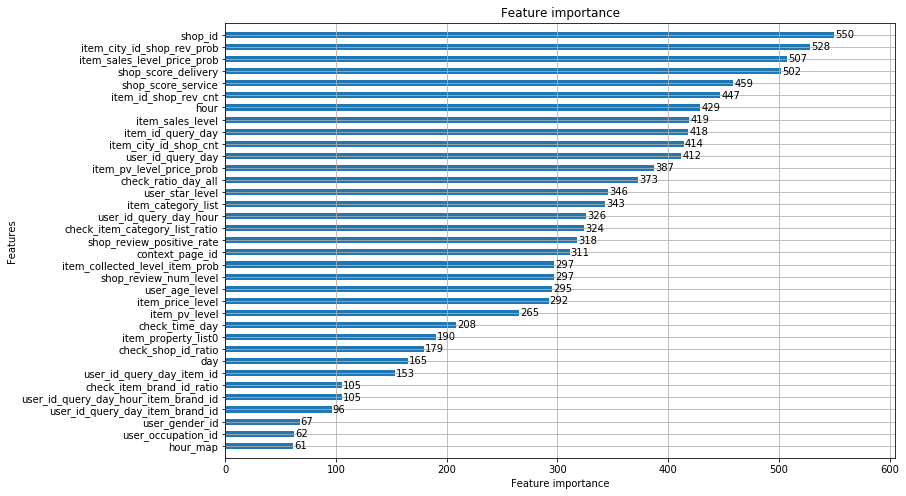

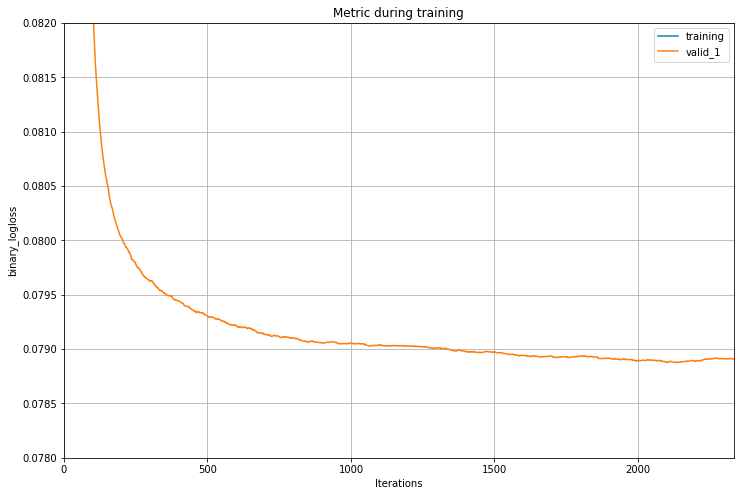

In [130]:
label = 'is_trade'
start_features = ['item_category_list', 
                  'item_price_level', 
                  'item_sales_level', 
                  #'item_collected_level', 
                  'item_pv_level', 
                  'user_gender_id', 
                  'user_age_level', 
                  'user_occupation_id', 
                  'user_star_level', 
                  'context_page_id', 
                  'shop_review_num_level', 
                  'shop_review_positive_rate', 
                  'shop_score_service', 
                  'shop_score_delivery', 
                  'hour', 
                  'day', 
                  'user_id_query_day_hour', 
                  'shop_id', 
                  'item_id_query_day', 
                  'user_id_query_day_item_brand_id', 
                  'user_id_query_day_hour_item_brand_id', 
                  'user_id_query_day',
                  #'item_brand_id',
                  'user_id_query_day_item_id', 
                  'check_item_brand_id_ratio',
                  'check_shop_id_ratio', 
                  'check_item_category_list_ratio', 
                  'check_ratio_day_all', 
                  'check_time_day', 
                  'item_city_id_shop_cnt', 
                  'item_city_id_shop_rev_prob', 
                  'item_id_shop_rev_cnt', 
                  'item_property_list0', 
                  'item_pv_level_price_prob', 
                  'item_collected_level_item_prob',
                  'item_sales_level_price_prob',
                  'hour_map'
                 ]
print(len(start_features))
clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=5000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=30)

clf = run(start_features, label, df, clf, True)
lgbm.plot_importance(clf,figsize=(12,8),height=0.5)
plt.show()
lgbm.plot_metric(clf,figsize=(12,8),ylim=(0.078,0.082))
plt.show()

In [10]:
df = df[~pd.isnull(df.is_trade)]

In [11]:
item_category_list_unique = list(np.unique(df.item_category_list))
df.item_category_list.replace(item_category_list_unique, list(np.arange(len(item_category_list_unique))), inplace=True)

In [129]:
label = 'is_trade'
start_features = ['item_category_list', 
                  'item_price_level', 
                  'item_sales_level', 
                  #'item_collected_level', 
                  'item_pv_level', 
                  'user_gender_id', 
                  'user_age_level', 
                  'user_occupation_id', 
                  'user_star_level', 
                  'context_page_id', 
                  'shop_review_num_level', 
                  'shop_review_positive_rate', 
                  'shop_score_service', 
                  'shop_score_delivery', 
                  'hour', 
                  'day', 
                  'user_id_query_day_hour', 
                  'shop_id', 
                  'item_id_query_day', 
                  'user_id_query_day_item_brand_id', 
                  'user_id_query_day_hour_item_brand_id', 
                  'user_id_query_day',
                  #'item_brand_id',
                  'user_id_query_day_item_id', 
                  'check_item_brand_id_ratio',
                  'check_shop_id_ratio', 
                  'check_item_category_list_ratio', 
                  'check_ratio_day_all', 
                  'check_time_day', 
                  'item_city_id_shop_cnt', 
                  'item_city_id_shop_rev_prob', 
                  'item_id_shop_rev_cnt', 
                  'item_property_list0', 
                  'item_pv_level_price_prob', 
                  'item_collected_level_item_prob',
                 'item_sales_level_price_prob',
                  'hour_map'
                 ]

for i in start_features[:]:
    x = start_features[:]
    x.remove(i)
    print(i)
    clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=5000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=30)

    clf = run(x, label, df, clf, False)

lgbm.plot_metric(clf,figsize=(12,8),ylim=(0.078,0.082))
plt.show()
fe = np.array(start_features)[np.argsort(clf.feature_importances_)][::-1]
for i,j in zip(fe, clf.feature_importances_[np.argsort(clf.feature_importances_)][::-1]):
    print('{}: {}'.format(i,j / np.sum(clf.feature_importances_)))

item_category_list
hour_map
0.07908337250089897
item_price_level
hour_map
0.07898326541487258
item_sales_level
hour_map
0.07933206256423324
item_collected_level
hour_map
0.07887566794491502
item_pv_level
hour_map
0.07888494646436925
user_gender_id
hour_map
0.07897607849879151
user_age_level
hour_map
0.07907987527332835
user_occupation_id
hour_map
0.07889917440032053
user_star_level
hour_map
0.07909446817772402
context_page_id
hour_map


KeyboardInterrupt: 

best update: 0.07962037953591194 -> 0.08154 

best update 0.07953425004195597 -> 0.08147 

best update: 0.079103 -> 0.08104
    
best update: 0.078783 -> 0.08099
    
best update: 0.078648 -> 0.08097
    
best update: 0.078731 -> 0.08096
    
best update: 0.078516 -> 0.08075

In [153]:
set(df2.columns) - set(df.columns)

{'check_context_page_id_ratio_hour_map',
 'check_context_page_id_time_day_hour_map',
 'check_item_brand_id_ratio_hour_map',
 'check_item_brand_id_time_day_hour_map',
 'check_item_category_list_ratio_hour_map',
 'check_item_category_list_time_day_hour_map',
 'check_item_collected_level_ratio_hour_map',
 'check_item_collected_level_time_day_hour_map',
 'check_item_id_ratio_hour_map',
 'check_item_id_time_day_hour_map',
 'check_item_price_level_ratio_hour_map',
 'check_item_price_level_time_day_hour_map',
 'check_item_pv_level_ratio_hour_map',
 'check_item_pv_level_time_day_hour_map',
 'check_item_sales_level_ratio_hour_map',
 'check_item_sales_level_time_day_hour_map',
 'check_ratio_day_hour_map_all',
 'check_shop_id_ratio_hour_map',
 'check_shop_id_time_day_hour_map',
 'check_time_day_hour_map',
 'hour_series',
 'item_brand_id_cnt1d',
 'item_brand_id_cnt1h',
 'item_brand_id_cntxd',
 'item_brand_id_cntxh',
 'item_brand_id_query_day_hour_map',
 'item_brand_id_query_min_map',
 'item_catego

In [194]:
label = 'is_trade'
start_features = ['item_category_list', 
                  'item_price_level', 
                  'item_sales_level', 
                  'item_collected_level', 
                  'user_gender_id', 
                  'user_age_level', 
                  'user_occupation_id', 
                  'user_star_level', 
                  'context_page_id', 
                  'shop_review_num_level', 
                  'shop_review_positive_rate', 
                  'shop_score_service', 
                  'hour', 
                  'day', 
                  'user_id_query_day_hour', 
                  'shop_id', 
                  'user_id_query_day_item_brand_id', 
                  'user_id_query_day_hour_item_brand_id', 
                  'user_id_query_day',
                  'user_id_query_day_item_id', 
                  'check_item_brand_id_ratio',
                  'check_shop_id_ratio', 
                  'check_item_category_list_ratio', 
                  'check_ratio_day_all', 
                  'check_time_day', 
                  'item_city_id_shop_cnt', 
                  'item_city_id_shop_rev_prob', 
                  'item_id_shop_rev_cnt', 
                  'item_property_list0', 
                  'item_pv_level_price_prob', 
                  'item_collected_level_item_prob',
                  'item_sales_level_price_prob',
                  'item_city_id_cnt1d',
                  'item_collected_level_user_age_cnt',
                 ]
print(len(start_features))
for i in start_features[:]: #list(set(df2.columns) - set(df.columns)):
    clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=20000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=30)
    print(i)
    x = start_features[:]
    x.remove(i)
    clf = run(x, label, df2, clf, False)

34
item_category_list
0.07897694576081914
item_price_level
0.07881237696853904
item_sales_level
0.07926779190809718
item_collected_level
0.07870309555145186
user_gender_id
0.07885951747469662
user_age_level
0.07883918938554887
user_occupation_id
0.0786957304170187
user_star_level
0.07883197689798484
context_page_id
0.0788491594132728
shop_review_num_level
0.07868922293899037
shop_review_positive_rate
0.07872629824000457
shop_score_service
0.07890666305366725
hour
0.0790805721464056
day
0.07872450502557643
user_id_query_day_hour
0.07878725431083271
shop_id
0.07875021689742986
user_id_query_day_item_brand_id
0.07874793512011298
user_id_query_day_hour_item_brand_id
0.07871572054613299
user_id_query_day
0.07893695827753043
user_id_query_day_item_id
0.07892253587153111
check_item_brand_id_ratio
0.07872721109219002
check_shop_id_ratio
0.07875439358420648
check_item_category_list_ratio
0.07875637994057735
check_ratio_day_all
0.07887851547486452
check_time_day
0.07877981388561418
item_city_id_

KeyboardInterrupt: 

[1]	training's binary_logloss: 0.648025	valid_1's binary_logloss: 0.647791
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_logloss: 0.607201	valid_1's binary_logloss: 0.606753
[3]	training's binary_logloss: 0.570105	valid_1's binary_logloss: 0.569448
[4]	training's binary_logloss: 0.536266	valid_1's binary_logloss: 0.535405
[5]	training's binary_logloss: 0.505299	valid_1's binary_logloss: 0.504246
[6]	training's binary_logloss: 0.476876	valid_1's binary_logloss: 0.475636
[7]	training's binary_logloss: 0.45072	valid_1's binary_logloss: 0.449296
[8]	training's binary_logloss: 0.426599	valid_1's binary_logloss: 0.425005
[9]	training's binary_logloss: 0.404308	valid_1's binary_logloss: 0.402548
[10]	training's binary_logloss: 0.383672	valid_1's binary_logloss: 0.381754
[11]	training's binary_logloss: 0.364536	valid_1's binary_logloss: 0.362466
[12]	training's binary_logloss: 0.346768	valid_1's binary_logloss: 0.344548
[13]	training's binary_logloss: 0.3

[107]	training's binary_logloss: 0.0896702	valid_1's binary_logloss: 0.0817775
[108]	training's binary_logloss: 0.0896225	valid_1's binary_logloss: 0.0817298
[109]	training's binary_logloss: 0.0895656	valid_1's binary_logloss: 0.0816711
[110]	training's binary_logloss: 0.0895117	valid_1's binary_logloss: 0.0816187
[111]	training's binary_logloss: 0.0894655	valid_1's binary_logloss: 0.0815674
[112]	training's binary_logloss: 0.0894281	valid_1's binary_logloss: 0.0815378
[113]	training's binary_logloss: 0.0893803	valid_1's binary_logloss: 0.0814892
[114]	training's binary_logloss: 0.0893413	valid_1's binary_logloss: 0.0814447
[115]	training's binary_logloss: 0.0893036	valid_1's binary_logloss: 0.0813952
[116]	training's binary_logloss: 0.0892588	valid_1's binary_logloss: 0.0813466
[117]	training's binary_logloss: 0.089224	valid_1's binary_logloss: 0.0813103
[118]	training's binary_logloss: 0.0891918	valid_1's binary_logloss: 0.0812792
[119]	training's binary_logloss: 0.0891587	valid_1's 

[211]	training's binary_logloss: 0.0874141	valid_1's binary_logloss: 0.0799186
[212]	training's binary_logloss: 0.0874056	valid_1's binary_logloss: 0.0799098
[213]	training's binary_logloss: 0.0873975	valid_1's binary_logloss: 0.0799043
[214]	training's binary_logloss: 0.0873872	valid_1's binary_logloss: 0.0798988
[215]	training's binary_logloss: 0.0873756	valid_1's binary_logloss: 0.0798918
[216]	training's binary_logloss: 0.0873677	valid_1's binary_logloss: 0.0798832
[217]	training's binary_logloss: 0.0873576	valid_1's binary_logloss: 0.0798779
[218]	training's binary_logloss: 0.0873428	valid_1's binary_logloss: 0.0798686
[219]	training's binary_logloss: 0.0873342	valid_1's binary_logloss: 0.079866
[220]	training's binary_logloss: 0.0873267	valid_1's binary_logloss: 0.0798669
[221]	training's binary_logloss: 0.0873177	valid_1's binary_logloss: 0.0798609
[222]	training's binary_logloss: 0.0873086	valid_1's binary_logloss: 0.0798611
[223]	training's binary_logloss: 0.0872973	valid_1's 

[315]	training's binary_logloss: 0.0866319	valid_1's binary_logloss: 0.0795228
[316]	training's binary_logloss: 0.0866264	valid_1's binary_logloss: 0.0795196
[317]	training's binary_logloss: 0.0866216	valid_1's binary_logloss: 0.0795202
[318]	training's binary_logloss: 0.0866151	valid_1's binary_logloss: 0.079511
[319]	training's binary_logloss: 0.0866081	valid_1's binary_logloss: 0.0795081
[320]	training's binary_logloss: 0.0866009	valid_1's binary_logloss: 0.0795074
[321]	training's binary_logloss: 0.086597	valid_1's binary_logloss: 0.0795033
[322]	training's binary_logloss: 0.0865904	valid_1's binary_logloss: 0.0794971
[323]	training's binary_logloss: 0.0865855	valid_1's binary_logloss: 0.0794971
[324]	training's binary_logloss: 0.086581	valid_1's binary_logloss: 0.0794946
[325]	training's binary_logloss: 0.0865767	valid_1's binary_logloss: 0.0794918
[326]	training's binary_logloss: 0.086571	valid_1's binary_logloss: 0.0794904
[327]	training's binary_logloss: 0.0865639	valid_1's bin

[420]	training's binary_logloss: 0.0861336	valid_1's binary_logloss: 0.0793179
[421]	training's binary_logloss: 0.0861287	valid_1's binary_logloss: 0.0793122
[422]	training's binary_logloss: 0.0861237	valid_1's binary_logloss: 0.0793107
[423]	training's binary_logloss: 0.08612	valid_1's binary_logloss: 0.0793119
[424]	training's binary_logloss: 0.0861169	valid_1's binary_logloss: 0.0793075
[425]	training's binary_logloss: 0.0861136	valid_1's binary_logloss: 0.0793078
[426]	training's binary_logloss: 0.0861107	valid_1's binary_logloss: 0.0793087
[427]	training's binary_logloss: 0.086105	valid_1's binary_logloss: 0.0793065
[428]	training's binary_logloss: 0.0860997	valid_1's binary_logloss: 0.0793069
[429]	training's binary_logloss: 0.0860958	valid_1's binary_logloss: 0.0793068
[430]	training's binary_logloss: 0.0860908	valid_1's binary_logloss: 0.0793048
[431]	training's binary_logloss: 0.0860866	valid_1's binary_logloss: 0.0793049
[432]	training's binary_logloss: 0.0860821	valid_1's bi

[525]	training's binary_logloss: 0.0857298	valid_1's binary_logloss: 0.0791629
[526]	training's binary_logloss: 0.0857265	valid_1's binary_logloss: 0.0791618
[527]	training's binary_logloss: 0.085723	valid_1's binary_logloss: 0.0791538
[528]	training's binary_logloss: 0.0857192	valid_1's binary_logloss: 0.0791534
[529]	training's binary_logloss: 0.0857157	valid_1's binary_logloss: 0.0791504
[530]	training's binary_logloss: 0.085712	valid_1's binary_logloss: 0.0791481
[531]	training's binary_logloss: 0.0857081	valid_1's binary_logloss: 0.0791475
[532]	training's binary_logloss: 0.0857053	valid_1's binary_logloss: 0.0791467
[533]	training's binary_logloss: 0.0857031	valid_1's binary_logloss: 0.079145
[534]	training's binary_logloss: 0.0856988	valid_1's binary_logloss: 0.0791444
[535]	training's binary_logloss: 0.0856943	valid_1's binary_logloss: 0.0791452
[536]	training's binary_logloss: 0.0856897	valid_1's binary_logloss: 0.0791422
[537]	training's binary_logloss: 0.0856872	valid_1's bi

[630]	training's binary_logloss: 0.0853873	valid_1's binary_logloss: 0.0790455
[631]	training's binary_logloss: 0.0853851	valid_1's binary_logloss: 0.0790455
[632]	training's binary_logloss: 0.0853823	valid_1's binary_logloss: 0.0790436
[633]	training's binary_logloss: 0.0853794	valid_1's binary_logloss: 0.0790436
[634]	training's binary_logloss: 0.0853767	valid_1's binary_logloss: 0.0790404
[635]	training's binary_logloss: 0.0853738	valid_1's binary_logloss: 0.0790387
[636]	training's binary_logloss: 0.0853719	valid_1's binary_logloss: 0.0790375
[637]	training's binary_logloss: 0.08537	valid_1's binary_logloss: 0.0790388
[638]	training's binary_logloss: 0.0853672	valid_1's binary_logloss: 0.0790382
[639]	training's binary_logloss: 0.0853648	valid_1's binary_logloss: 0.0790366
[640]	training's binary_logloss: 0.0853621	valid_1's binary_logloss: 0.0790354
[641]	training's binary_logloss: 0.0853594	valid_1's binary_logloss: 0.0790325
[642]	training's binary_logloss: 0.0853555	valid_1's b

[734]	training's binary_logloss: 0.0851144	valid_1's binary_logloss: 0.0789793
[735]	training's binary_logloss: 0.0851109	valid_1's binary_logloss: 0.0789739
[736]	training's binary_logloss: 0.0851093	valid_1's binary_logloss: 0.0789749
[737]	training's binary_logloss: 0.0851053	valid_1's binary_logloss: 0.0789779
[738]	training's binary_logloss: 0.0851015	valid_1's binary_logloss: 0.0789803
[739]	training's binary_logloss: 0.0850983	valid_1's binary_logloss: 0.0789787
[740]	training's binary_logloss: 0.0850946	valid_1's binary_logloss: 0.0789782
[741]	training's binary_logloss: 0.0850928	valid_1's binary_logloss: 0.0789768
[742]	training's binary_logloss: 0.0850912	valid_1's binary_logloss: 0.0789745
[743]	training's binary_logloss: 0.0850903	valid_1's binary_logloss: 0.0789742
[744]	training's binary_logloss: 0.0850875	valid_1's binary_logloss: 0.0789766
[745]	training's binary_logloss: 0.0850846	valid_1's binary_logloss: 0.0789766
[746]	training's binary_logloss: 0.0850814	valid_1's

[839]	training's binary_logloss: 0.0848486	valid_1's binary_logloss: 0.0789334
[840]	training's binary_logloss: 0.0848472	valid_1's binary_logloss: 0.0789345
[841]	training's binary_logloss: 0.0848447	valid_1's binary_logloss: 0.0789356
[842]	training's binary_logloss: 0.0848419	valid_1's binary_logloss: 0.0789352
[843]	training's binary_logloss: 0.0848399	valid_1's binary_logloss: 0.0789338
[844]	training's binary_logloss: 0.0848386	valid_1's binary_logloss: 0.0789324
[845]	training's binary_logloss: 0.0848369	valid_1's binary_logloss: 0.0789327
[846]	training's binary_logloss: 0.084836	valid_1's binary_logloss: 0.0789326
[847]	training's binary_logloss: 0.0848332	valid_1's binary_logloss: 0.0789323
[848]	training's binary_logloss: 0.0848313	valid_1's binary_logloss: 0.0789329
[849]	training's binary_logloss: 0.0848273	valid_1's binary_logloss: 0.0789306
[850]	training's binary_logloss: 0.0848269	valid_1's binary_logloss: 0.0789298
[851]	training's binary_logloss: 0.0848242	valid_1's 

[945]	training's binary_logloss: 0.08459	valid_1's binary_logloss: 0.0788728
[946]	training's binary_logloss: 0.0845886	valid_1's binary_logloss: 0.078873
[947]	training's binary_logloss: 0.0845852	valid_1's binary_logloss: 0.0788726
[948]	training's binary_logloss: 0.0845817	valid_1's binary_logloss: 0.0788736
[949]	training's binary_logloss: 0.0845813	valid_1's binary_logloss: 0.0788736
[950]	training's binary_logloss: 0.0845802	valid_1's binary_logloss: 0.0788736
[951]	training's binary_logloss: 0.0845789	valid_1's binary_logloss: 0.0788741
[952]	training's binary_logloss: 0.0845767	valid_1's binary_logloss: 0.0788722
[953]	training's binary_logloss: 0.0845742	valid_1's binary_logloss: 0.0788743
[954]	training's binary_logloss: 0.0845719	valid_1's binary_logloss: 0.0788742
[955]	training's binary_logloss: 0.0845696	valid_1's binary_logloss: 0.078874
[956]	training's binary_logloss: 0.0845683	valid_1's binary_logloss: 0.0788751
[957]	training's binary_logloss: 0.084566	valid_1's bina

[1049]	training's binary_logloss: 0.0843535	valid_1's binary_logloss: 0.0788552
[1050]	training's binary_logloss: 0.0843525	valid_1's binary_logloss: 0.0788559
[1051]	training's binary_logloss: 0.0843514	valid_1's binary_logloss: 0.0788566
[1052]	training's binary_logloss: 0.0843491	valid_1's binary_logloss: 0.078855
[1053]	training's binary_logloss: 0.0843464	valid_1's binary_logloss: 0.0788519
[1054]	training's binary_logloss: 0.0843445	valid_1's binary_logloss: 0.0788526
[1055]	training's binary_logloss: 0.0843433	valid_1's binary_logloss: 0.0788541
[1056]	training's binary_logloss: 0.0843403	valid_1's binary_logloss: 0.0788559
[1057]	training's binary_logloss: 0.0843374	valid_1's binary_logloss: 0.0788554
[1058]	training's binary_logloss: 0.0843342	valid_1's binary_logloss: 0.0788522
[1059]	training's binary_logloss: 0.084332	valid_1's binary_logloss: 0.0788517
[1060]	training's binary_logloss: 0.0843289	valid_1's binary_logloss: 0.0788511
[1061]	training's binary_logloss: 0.084326

[1152]	training's binary_logloss: 0.0841259	valid_1's binary_logloss: 0.0788246
[1153]	training's binary_logloss: 0.0841241	valid_1's binary_logloss: 0.0788249
[1154]	training's binary_logloss: 0.0841236	valid_1's binary_logloss: 0.0788242
[1155]	training's binary_logloss: 0.0841219	valid_1's binary_logloss: 0.0788241
[1156]	training's binary_logloss: 0.0841203	valid_1's binary_logloss: 0.0788237
[1157]	training's binary_logloss: 0.0841183	valid_1's binary_logloss: 0.0788221
[1158]	training's binary_logloss: 0.084116	valid_1's binary_logloss: 0.0788216
[1159]	training's binary_logloss: 0.0841132	valid_1's binary_logloss: 0.0788231
[1160]	training's binary_logloss: 0.0841107	valid_1's binary_logloss: 0.0788251
[1161]	training's binary_logloss: 0.0841068	valid_1's binary_logloss: 0.0788245
[1162]	training's binary_logloss: 0.0841046	valid_1's binary_logloss: 0.0788243
[1163]	training's binary_logloss: 0.0841023	valid_1's binary_logloss: 0.078822
[1164]	training's binary_logloss: 0.084099

[1256]	training's binary_logloss: 0.0838952	valid_1's binary_logloss: 0.0788121
[1257]	training's binary_logloss: 0.0838934	valid_1's binary_logloss: 0.0788138
[1258]	training's binary_logloss: 0.083891	valid_1's binary_logloss: 0.0788143
[1259]	training's binary_logloss: 0.0838891	valid_1's binary_logloss: 0.0788123
[1260]	training's binary_logloss: 0.0838887	valid_1's binary_logloss: 0.0788118
[1261]	training's binary_logloss: 0.083888	valid_1's binary_logloss: 0.0788125
[1262]	training's binary_logloss: 0.0838856	valid_1's binary_logloss: 0.0788125
[1263]	training's binary_logloss: 0.0838838	valid_1's binary_logloss: 0.07881
[1264]	training's binary_logloss: 0.0838815	valid_1's binary_logloss: 0.0788111
[1265]	training's binary_logloss: 0.0838801	valid_1's binary_logloss: 0.0788119
[1266]	training's binary_logloss: 0.0838781	valid_1's binary_logloss: 0.078813
[1267]	training's binary_logloss: 0.0838765	valid_1's binary_logloss: 0.0788126
[1268]	training's binary_logloss: 0.0838747	v

[1359]	training's binary_logloss: 0.0836939	valid_1's binary_logloss: 0.0787918
[1360]	training's binary_logloss: 0.0836906	valid_1's binary_logloss: 0.0787927
[1361]	training's binary_logloss: 0.0836894	valid_1's binary_logloss: 0.0787915
[1362]	training's binary_logloss: 0.0836872	valid_1's binary_logloss: 0.0787918
[1363]	training's binary_logloss: 0.0836859	valid_1's binary_logloss: 0.0787924
[1364]	training's binary_logloss: 0.0836836	valid_1's binary_logloss: 0.0787947
[1365]	training's binary_logloss: 0.0836816	valid_1's binary_logloss: 0.0787941
[1366]	training's binary_logloss: 0.0836793	valid_1's binary_logloss: 0.0787969
[1367]	training's binary_logloss: 0.0836778	valid_1's binary_logloss: 0.0787949
[1368]	training's binary_logloss: 0.0836761	valid_1's binary_logloss: 0.0787956
[1369]	training's binary_logloss: 0.0836726	valid_1's binary_logloss: 0.0787941
[1370]	training's binary_logloss: 0.0836709	valid_1's binary_logloss: 0.0787936
[1371]	training's binary_logloss: 0.0836

[1463]	training's binary_logloss: 0.0834881	valid_1's binary_logloss: 0.0787648
[1464]	training's binary_logloss: 0.0834862	valid_1's binary_logloss: 0.0787647
[1465]	training's binary_logloss: 0.0834846	valid_1's binary_logloss: 0.0787635
[1466]	training's binary_logloss: 0.0834824	valid_1's binary_logloss: 0.0787649
[1467]	training's binary_logloss: 0.0834806	valid_1's binary_logloss: 0.0787663
[1468]	training's binary_logloss: 0.0834771	valid_1's binary_logloss: 0.0787673
[1469]	training's binary_logloss: 0.083475	valid_1's binary_logloss: 0.078766
[1470]	training's binary_logloss: 0.0834725	valid_1's binary_logloss: 0.0787666
[1471]	training's binary_logloss: 0.08347	valid_1's binary_logloss: 0.0787682
[1472]	training's binary_logloss: 0.0834685	valid_1's binary_logloss: 0.0787665
[1473]	training's binary_logloss: 0.0834661	valid_1's binary_logloss: 0.0787649
[1474]	training's binary_logloss: 0.0834651	valid_1's binary_logloss: 0.0787644
[1475]	training's binary_logloss: 0.0834628	

[1566]	training's binary_logloss: 0.0832995	valid_1's binary_logloss: 0.078773
[1567]	training's binary_logloss: 0.0832977	valid_1's binary_logloss: 0.0787743
[1568]	training's binary_logloss: 0.0832966	valid_1's binary_logloss: 0.0787759
[1569]	training's binary_logloss: 0.0832945	valid_1's binary_logloss: 0.0787763
[1570]	training's binary_logloss: 0.0832933	valid_1's binary_logloss: 0.078778
[1571]	training's binary_logloss: 0.0832922	valid_1's binary_logloss: 0.0787784
[1572]	training's binary_logloss: 0.0832908	valid_1's binary_logloss: 0.0787784
[1573]	training's binary_logloss: 0.0832891	valid_1's binary_logloss: 0.078778
[1574]	training's binary_logloss: 0.0832845	valid_1's binary_logloss: 0.0787792
[1575]	training's binary_logloss: 0.0832822	valid_1's binary_logloss: 0.0787814
[1576]	training's binary_logloss: 0.0832808	valid_1's binary_logloss: 0.0787821
[1577]	training's binary_logloss: 0.0832784	valid_1's binary_logloss: 0.0787803
[1578]	training's binary_logloss: 0.0832768

[1671]	training's binary_logloss: 0.0831097	valid_1's binary_logloss: 0.0787854
[1672]	training's binary_logloss: 0.0831071	valid_1's binary_logloss: 0.0787863
[1673]	training's binary_logloss: 0.0831051	valid_1's binary_logloss: 0.0787836
[1674]	training's binary_logloss: 0.083103	valid_1's binary_logloss: 0.0787846
[1675]	training's binary_logloss: 0.0831004	valid_1's binary_logloss: 0.0787857
[1676]	training's binary_logloss: 0.0830981	valid_1's binary_logloss: 0.0787855
[1677]	training's binary_logloss: 0.0830959	valid_1's binary_logloss: 0.0787887
[1678]	training's binary_logloss: 0.0830937	valid_1's binary_logloss: 0.0787863
[1679]	training's binary_logloss: 0.0830917	valid_1's binary_logloss: 0.0787834
[1680]	training's binary_logloss: 0.0830897	valid_1's binary_logloss: 0.0787808
[1681]	training's binary_logloss: 0.083088	valid_1's binary_logloss: 0.078781
[1682]	training's binary_logloss: 0.0830862	valid_1's binary_logloss: 0.0787789
[1683]	training's binary_logloss: 0.0830856

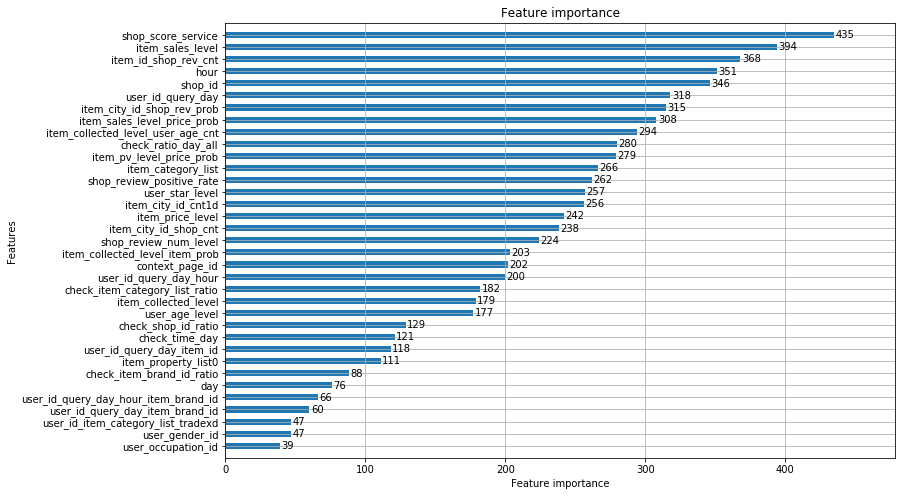

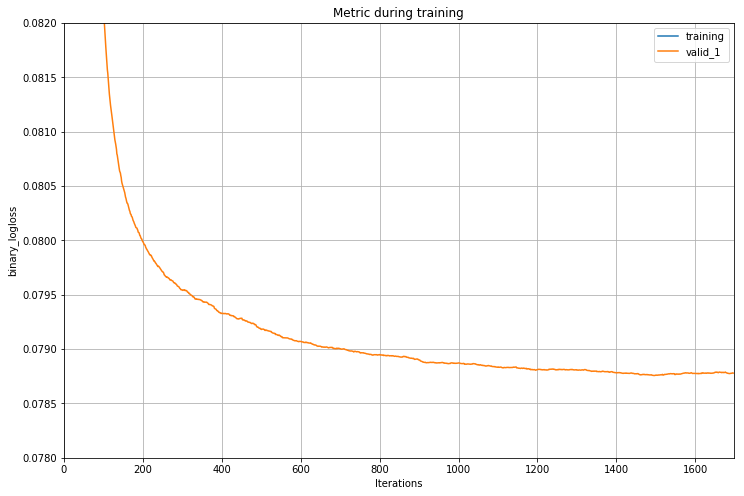

In [238]:
label = 'is_trade'
start_features = ['item_category_list', 
                  'item_price_level', 
                  'item_sales_level', 
                  'item_collected_level', 
                  'user_gender_id', 
                  'user_age_level', 
                  'user_occupation_id', 
                  'user_star_level', 
                  'context_page_id', 
                  'shop_review_num_level', 
                  'shop_review_positive_rate', 
                  'shop_score_service', 
                  'hour', 
                  'day', 
                  'user_id_query_day_hour', 
                  'shop_id', 
                  'user_id_query_day_item_brand_id', 
                  'user_id_query_day_hour_item_brand_id', 
                  'user_id_query_day',
                  'user_id_query_day_item_id', 
                  'check_item_brand_id_ratio',
                  'check_shop_id_ratio', 
                  'check_item_category_list_ratio', 
                  'check_ratio_day_all', 
                  'check_time_day', 
                  'item_city_id_shop_cnt', 
                  'item_city_id_shop_rev_prob', 
                  'item_id_shop_rev_cnt', 
                  'item_property_list0', 
                  'item_pv_level_price_prob', 
                  'item_collected_level_item_prob',
                  'item_sales_level_price_prob',
                  'item_city_id_cnt1d',
                  'item_collected_level_user_age_cnt',
                  'user_id_item_category_list_tradexd',
                 ]
clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=20000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=30)
clf = run(start_features, label, df2, clf, True)
lgbm.plot_importance(clf,figsize=(12,8),height=0.5)
plt.show()
lgbm.plot_metric(clf,figsize=(12,8),ylim=(0.078,0.082))
plt.show()

In [174]:
t1 = ['item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_page_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_score_service', 'shop_score_delivery', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'item_id_query_day', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'item_brand_id', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'check_time_day', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob']
t2 = ['item_category_list', 
                  'item_price_level', 
                  'item_sales_level', 
                  'item_collected_level', 
                  #'item_pv_level', 
                  'user_gender_id', 
                  'user_age_level', 
                  'user_occupation_id', 
                  'user_star_level', 
                  'context_page_id', 
                  'shop_review_num_level', 
                  'shop_review_positive_rate', 
                  'shop_score_service', 
                  #'shop_score_delivery', 
                  'hour', 
                  'day', 
                  'user_id_query_day_hour', 
                  'shop_id', 
                  #'item_id_query_day', 
                  'user_id_query_day_item_brand_id', 
                  'user_id_query_day_hour_item_brand_id', 
                  'user_id_query_day',
                  #'item_brand_id',
                  'user_id_query_day_item_id', 
                  'check_item_brand_id_ratio',
                  'check_shop_id_ratio', 
                  'check_item_category_list_ratio', 
                  'check_ratio_day_all', 
                  'check_time_day', 
                  'item_city_id_shop_cnt', 
                  'item_city_id_shop_rev_prob', 
                  'item_id_shop_rev_cnt', 
                  'item_property_list0', 
                  'item_pv_level_price_prob', 
                  'item_collected_level_item_prob',
                  'item_sales_level_price_prob',
                  'item_city_id_cnt1d',
                 ]

In [175]:
set(t1) - set(t2)

{'item_brand_id', 'item_id_query_day', 'item_pv_level', 'shop_score_delivery'}

In [176]:
set(t2) - set(t1)

{'item_city_id_cnt1d'}

In [7]:
label = 'is_trade'
start_features =['item_city_id_brand_prob','item_price_level_brand_cnt','item_brand_id_user_prob',
                 'check_min_difference_ahead',
                 'item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'item_price_level_item_cnt', 'item_price_level_item_prob', 
                'user_id_item_category_list_tradexd','item_brand_id_shop_rev_cnt','item_brand_id_shop_rev_prob',
                 'user_occupation_id_user_age_cnt'
                ]
clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=20000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=8)
for i in df2.columns[:]:
    if ('prob' in i) and (i not in start_features):
        print(i)
        clf = run(start_features + [i], label, df2, clf, False)
        print(clf.best_iteration_)

user_id_item_prob
0.07816241341274342
2463
item_brand_id_item_prob
0.07809818359951733
2270
item_city_id_item_prob
0.07797974661180278
2544
item_sales_level_item_prob
0.07813913637633293
1963
item_pv_level_item_prob
0.07818995818510385
2054
user_id_brand_prob
0.0781298807629214
1878
item_price_level_brand_prob
0.07811168502338355
1761
item_sales_level_brand_prob
0.07805639759135354
2419
item_collected_level_brand_prob
0.07809663613049968
2069
item_pv_level_brand_prob
0.07820459532952145
1966
item_price_level_city_prob
0.07814562095007584
2443
item_sales_level_city_prob
0.07811483141493426
2183
item_collected_level_city_prob
0.07806053193465876
2547
item_pv_level_city_prob
0.07820035187424819
1980
user_id_price_prob
0.07812697551313548
2414
item_collected_level_price_prob
0.07824245739788944
1822
user_id_salse_prob
0.07818856907543908
1740
item_collected_level_salse_prob
0.07808757969613822
2208
item_pv_level_salse_prob
0.07809636620295776
2828
user_id_coll_prob
0.07807097175773305
2418

KeyboardInterrupt: 

[1]	training's binary_logloss: 0.648015	valid_1's binary_logloss: 0.647877
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_logloss: 0.607184	valid_1's binary_logloss: 0.606907
[3]	training's binary_logloss: 0.570081	valid_1's binary_logloss: 0.569654
[4]	training's binary_logloss: 0.536235	valid_1's binary_logloss: 0.535675
[5]	training's binary_logloss: 0.50526	valid_1's binary_logloss: 0.504544
[6]	training's binary_logloss: 0.47683	valid_1's binary_logloss: 0.475978
[7]	training's binary_logloss: 0.450669	valid_1's binary_logloss: 0.44968
[8]	training's binary_logloss: 0.42654	valid_1's binary_logloss: 0.425424
[9]	training's binary_logloss: 0.404241	valid_1's binary_logloss: 0.40299
[10]	training's binary_logloss: 0.383598	valid_1's binary_logloss: 0.382212
[11]	training's binary_logloss: 0.364456	valid_1's binary_logloss: 0.362947
[12]	training's binary_logloss: 0.34668	valid_1's binary_logloss: 0.345036
[13]	training's binary_logloss: 0.330152

[110]	training's binary_logloss: 0.0889714	valid_1's binary_logloss: 0.0816173
[111]	training's binary_logloss: 0.0889239	valid_1's binary_logloss: 0.0815598
[112]	training's binary_logloss: 0.0888756	valid_1's binary_logloss: 0.0815055
[113]	training's binary_logloss: 0.0888355	valid_1's binary_logloss: 0.0814593
[114]	training's binary_logloss: 0.0887939	valid_1's binary_logloss: 0.0814247
[115]	training's binary_logloss: 0.0887533	valid_1's binary_logloss: 0.0813805
[116]	training's binary_logloss: 0.0887102	valid_1's binary_logloss: 0.0813355
[117]	training's binary_logloss: 0.0886732	valid_1's binary_logloss: 0.0812951
[118]	training's binary_logloss: 0.0886381	valid_1's binary_logloss: 0.081259
[119]	training's binary_logloss: 0.0885901	valid_1's binary_logloss: 0.0812164
[120]	training's binary_logloss: 0.0885499	valid_1's binary_logloss: 0.0811768
[121]	training's binary_logloss: 0.088511	valid_1's binary_logloss: 0.0811369
[122]	training's binary_logloss: 0.0884699	valid_1's b

[215]	training's binary_logloss: 0.0867111	valid_1's binary_logloss: 0.079733
[216]	training's binary_logloss: 0.0867014	valid_1's binary_logloss: 0.0797299
[217]	training's binary_logloss: 0.0866923	valid_1's binary_logloss: 0.0797176
[218]	training's binary_logloss: 0.0866847	valid_1's binary_logloss: 0.0797158
[219]	training's binary_logloss: 0.0866721	valid_1's binary_logloss: 0.0797048
[220]	training's binary_logloss: 0.0866556	valid_1's binary_logloss: 0.0796964
[221]	training's binary_logloss: 0.0866437	valid_1's binary_logloss: 0.0796927
[222]	training's binary_logloss: 0.0866301	valid_1's binary_logloss: 0.0796857
[223]	training's binary_logloss: 0.0866187	valid_1's binary_logloss: 0.0796703
[224]	training's binary_logloss: 0.0866091	valid_1's binary_logloss: 0.0796675
[225]	training's binary_logloss: 0.0865991	valid_1's binary_logloss: 0.079659
[226]	training's binary_logloss: 0.0865909	valid_1's binary_logloss: 0.079651
[227]	training's binary_logloss: 0.0865772	valid_1's bi

[323]	training's binary_logloss: 0.0858221	valid_1's binary_logloss: 0.0791882
[324]	training's binary_logloss: 0.0858172	valid_1's binary_logloss: 0.0791858
[325]	training's binary_logloss: 0.0858125	valid_1's binary_logloss: 0.079188
[326]	training's binary_logloss: 0.0858081	valid_1's binary_logloss: 0.0791865
[327]	training's binary_logloss: 0.0858024	valid_1's binary_logloss: 0.0791877
[328]	training's binary_logloss: 0.0857962	valid_1's binary_logloss: 0.0791869
[329]	training's binary_logloss: 0.0857892	valid_1's binary_logloss: 0.0791869
[330]	training's binary_logloss: 0.0857807	valid_1's binary_logloss: 0.0791787
[331]	training's binary_logloss: 0.0857767	valid_1's binary_logloss: 0.079177
[332]	training's binary_logloss: 0.0857697	valid_1's binary_logloss: 0.0791744
[333]	training's binary_logloss: 0.0857638	valid_1's binary_logloss: 0.079168
[334]	training's binary_logloss: 0.0857576	valid_1's binary_logloss: 0.0791633
[335]	training's binary_logloss: 0.0857529	valid_1's bi

[432]	training's binary_logloss: 0.085255	valid_1's binary_logloss: 0.0788939
[433]	training's binary_logloss: 0.0852499	valid_1's binary_logloss: 0.0788904
[434]	training's binary_logloss: 0.0852438	valid_1's binary_logloss: 0.0788925
[435]	training's binary_logloss: 0.0852411	valid_1's binary_logloss: 0.0788929
[436]	training's binary_logloss: 0.0852385	valid_1's binary_logloss: 0.0788916
[437]	training's binary_logloss: 0.0852334	valid_1's binary_logloss: 0.0788834
[438]	training's binary_logloss: 0.0852291	valid_1's binary_logloss: 0.0788828
[439]	training's binary_logloss: 0.0852236	valid_1's binary_logloss: 0.0788832
[440]	training's binary_logloss: 0.0852199	valid_1's binary_logloss: 0.0788845
[441]	training's binary_logloss: 0.0852157	valid_1's binary_logloss: 0.0788832
[442]	training's binary_logloss: 0.0852069	valid_1's binary_logloss: 0.0788805
[443]	training's binary_logloss: 0.0852012	valid_1's binary_logloss: 0.0788801
[444]	training's binary_logloss: 0.0851952	valid_1's 

[543]	training's binary_logloss: 0.0847885	valid_1's binary_logloss: 0.0786925
[544]	training's binary_logloss: 0.084787	valid_1's binary_logloss: 0.0786926
[545]	training's binary_logloss: 0.0847831	valid_1's binary_logloss: 0.0786942
[546]	training's binary_logloss: 0.0847802	valid_1's binary_logloss: 0.0786923
[547]	training's binary_logloss: 0.0847759	valid_1's binary_logloss: 0.0786919
[548]	training's binary_logloss: 0.0847729	valid_1's binary_logloss: 0.0786913
[549]	training's binary_logloss: 0.0847699	valid_1's binary_logloss: 0.0786929
[550]	training's binary_logloss: 0.084765	valid_1's binary_logloss: 0.0786895
[551]	training's binary_logloss: 0.0847595	valid_1's binary_logloss: 0.0786898
[552]	training's binary_logloss: 0.0847546	valid_1's binary_logloss: 0.0786853
[553]	training's binary_logloss: 0.0847492	valid_1's binary_logloss: 0.0786828
[554]	training's binary_logloss: 0.0847458	valid_1's binary_logloss: 0.0786821
[555]	training's binary_logloss: 0.0847424	valid_1's b

[653]	training's binary_logloss: 0.0844067	valid_1's binary_logloss: 0.0785663
[654]	training's binary_logloss: 0.0844038	valid_1's binary_logloss: 0.0785655
[655]	training's binary_logloss: 0.0843999	valid_1's binary_logloss: 0.0785642
[656]	training's binary_logloss: 0.0843963	valid_1's binary_logloss: 0.0785655
[657]	training's binary_logloss: 0.0843936	valid_1's binary_logloss: 0.0785672
[658]	training's binary_logloss: 0.0843908	valid_1's binary_logloss: 0.0785677
[659]	training's binary_logloss: 0.0843867	valid_1's binary_logloss: 0.0785649
[660]	training's binary_logloss: 0.0843837	valid_1's binary_logloss: 0.078565
[661]	training's binary_logloss: 0.0843802	valid_1's binary_logloss: 0.0785642
[662]	training's binary_logloss: 0.0843777	valid_1's binary_logloss: 0.0785656
[663]	training's binary_logloss: 0.0843744	valid_1's binary_logloss: 0.0785625
[664]	training's binary_logloss: 0.0843712	valid_1's binary_logloss: 0.0785639
[665]	training's binary_logloss: 0.0843678	valid_1's 

[761]	training's binary_logloss: 0.084074	valid_1's binary_logloss: 0.0784892
[762]	training's binary_logloss: 0.0840721	valid_1's binary_logloss: 0.0784899
[763]	training's binary_logloss: 0.0840709	valid_1's binary_logloss: 0.0784902
[764]	training's binary_logloss: 0.0840669	valid_1's binary_logloss: 0.0784881
[765]	training's binary_logloss: 0.0840648	valid_1's binary_logloss: 0.0784886
[766]	training's binary_logloss: 0.0840564	valid_1's binary_logloss: 0.0784855
[767]	training's binary_logloss: 0.084053	valid_1's binary_logloss: 0.0784841
[768]	training's binary_logloss: 0.0840506	valid_1's binary_logloss: 0.0784828
[769]	training's binary_logloss: 0.0840481	valid_1's binary_logloss: 0.0784867
[770]	training's binary_logloss: 0.0840453	valid_1's binary_logloss: 0.0784851
[771]	training's binary_logloss: 0.0840421	valid_1's binary_logloss: 0.0784824
[772]	training's binary_logloss: 0.0840391	valid_1's binary_logloss: 0.078477
[773]	training's binary_logloss: 0.0840359	valid_1's bi

[870]	training's binary_logloss: 0.0837577	valid_1's binary_logloss: 0.0784089
[871]	training's binary_logloss: 0.0837562	valid_1's binary_logloss: 0.0784054
[872]	training's binary_logloss: 0.083754	valid_1's binary_logloss: 0.0784028
[873]	training's binary_logloss: 0.0837521	valid_1's binary_logloss: 0.078401
[874]	training's binary_logloss: 0.0837505	valid_1's binary_logloss: 0.0784007
[875]	training's binary_logloss: 0.0837471	valid_1's binary_logloss: 0.0784025
[876]	training's binary_logloss: 0.0837431	valid_1's binary_logloss: 0.0784021
[877]	training's binary_logloss: 0.0837391	valid_1's binary_logloss: 0.0784016
[878]	training's binary_logloss: 0.0837366	valid_1's binary_logloss: 0.0784006
[879]	training's binary_logloss: 0.0837334	valid_1's binary_logloss: 0.0784011
[880]	training's binary_logloss: 0.0837303	valid_1's binary_logloss: 0.0784015
[881]	training's binary_logloss: 0.0837276	valid_1's binary_logloss: 0.0784021
[882]	training's binary_logloss: 0.0837237	valid_1's b

[975]	training's binary_logloss: 0.0834743	valid_1's binary_logloss: 0.0783723
[976]	training's binary_logloss: 0.0834717	valid_1's binary_logloss: 0.0783709
[977]	training's binary_logloss: 0.0834667	valid_1's binary_logloss: 0.0783681
[978]	training's binary_logloss: 0.0834623	valid_1's binary_logloss: 0.0783689
[979]	training's binary_logloss: 0.0834598	valid_1's binary_logloss: 0.0783671
[980]	training's binary_logloss: 0.0834568	valid_1's binary_logloss: 0.0783667
[981]	training's binary_logloss: 0.0834528	valid_1's binary_logloss: 0.0783654
[982]	training's binary_logloss: 0.0834503	valid_1's binary_logloss: 0.0783642
[983]	training's binary_logloss: 0.0834469	valid_1's binary_logloss: 0.0783646
[984]	training's binary_logloss: 0.0834436	valid_1's binary_logloss: 0.078367
[985]	training's binary_logloss: 0.0834404	valid_1's binary_logloss: 0.0783664
[986]	training's binary_logloss: 0.0834379	valid_1's binary_logloss: 0.0783659
[987]	training's binary_logloss: 0.0834363	valid_1's 

[1080]	training's binary_logloss: 0.0832053	valid_1's binary_logloss: 0.0783289
[1081]	training's binary_logloss: 0.0832019	valid_1's binary_logloss: 0.0783291
[1082]	training's binary_logloss: 0.0831994	valid_1's binary_logloss: 0.0783293
[1083]	training's binary_logloss: 0.0831965	valid_1's binary_logloss: 0.078327
[1084]	training's binary_logloss: 0.083194	valid_1's binary_logloss: 0.0783273
[1085]	training's binary_logloss: 0.0831916	valid_1's binary_logloss: 0.0783274
[1086]	training's binary_logloss: 0.0831891	valid_1's binary_logloss: 0.0783264
[1087]	training's binary_logloss: 0.0831878	valid_1's binary_logloss: 0.0783277
[1088]	training's binary_logloss: 0.0831867	valid_1's binary_logloss: 0.0783275
[1089]	training's binary_logloss: 0.0831839	valid_1's binary_logloss: 0.0783292
[1090]	training's binary_logloss: 0.0831829	valid_1's binary_logloss: 0.0783291
[1091]	training's binary_logloss: 0.0831784	valid_1's binary_logloss: 0.0783316
[1092]	training's binary_logloss: 0.083176

[1186]	training's binary_logloss: 0.0829443	valid_1's binary_logloss: 0.0783203
[1187]	training's binary_logloss: 0.0829423	valid_1's binary_logloss: 0.0783192
[1188]	training's binary_logloss: 0.0829409	valid_1's binary_logloss: 0.0783172
[1189]	training's binary_logloss: 0.0829391	valid_1's binary_logloss: 0.0783169
[1190]	training's binary_logloss: 0.0829366	valid_1's binary_logloss: 0.0783168
[1191]	training's binary_logloss: 0.0829347	valid_1's binary_logloss: 0.0783162
[1192]	training's binary_logloss: 0.082932	valid_1's binary_logloss: 0.0783149
[1193]	training's binary_logloss: 0.0829306	valid_1's binary_logloss: 0.0783154
[1194]	training's binary_logloss: 0.0829281	valid_1's binary_logloss: 0.0783153
[1195]	training's binary_logloss: 0.0829256	valid_1's binary_logloss: 0.0783126
[1196]	training's binary_logloss: 0.082924	valid_1's binary_logloss: 0.078313
[1197]	training's binary_logloss: 0.0829215	valid_1's binary_logloss: 0.0783122
[1198]	training's binary_logloss: 0.0829185

[1293]	training's binary_logloss: 0.0826935	valid_1's binary_logloss: 0.0782811
[1294]	training's binary_logloss: 0.0826925	valid_1's binary_logloss: 0.0782806
[1295]	training's binary_logloss: 0.0826893	valid_1's binary_logloss: 0.0782806
[1296]	training's binary_logloss: 0.0826862	valid_1's binary_logloss: 0.0782724
[1297]	training's binary_logloss: 0.0826829	valid_1's binary_logloss: 0.0782745
[1298]	training's binary_logloss: 0.0826811	valid_1's binary_logloss: 0.0782733
[1299]	training's binary_logloss: 0.0826785	valid_1's binary_logloss: 0.0782722
[1300]	training's binary_logloss: 0.0826763	valid_1's binary_logloss: 0.078272
[1301]	training's binary_logloss: 0.0826745	valid_1's binary_logloss: 0.0782714
[1302]	training's binary_logloss: 0.0826726	valid_1's binary_logloss: 0.0782716
[1303]	training's binary_logloss: 0.0826703	valid_1's binary_logloss: 0.0782728
[1304]	training's binary_logloss: 0.0826695	valid_1's binary_logloss: 0.0782731
[1305]	training's binary_logloss: 0.08266

[1396]	training's binary_logloss: 0.0824614	valid_1's binary_logloss: 0.0782369
[1397]	training's binary_logloss: 0.0824595	valid_1's binary_logloss: 0.0782351
[1398]	training's binary_logloss: 0.0824589	valid_1's binary_logloss: 0.078234
[1399]	training's binary_logloss: 0.0824574	valid_1's binary_logloss: 0.0782336
[1400]	training's binary_logloss: 0.0824551	valid_1's binary_logloss: 0.0782361
[1401]	training's binary_logloss: 0.082453	valid_1's binary_logloss: 0.0782363
[1402]	training's binary_logloss: 0.082451	valid_1's binary_logloss: 0.0782373
[1403]	training's binary_logloss: 0.0824478	valid_1's binary_logloss: 0.0782365
[1404]	training's binary_logloss: 0.0824464	valid_1's binary_logloss: 0.0782363
[1405]	training's binary_logloss: 0.082444	valid_1's binary_logloss: 0.0782363
[1406]	training's binary_logloss: 0.0824395	valid_1's binary_logloss: 0.0782359
[1407]	training's binary_logloss: 0.0824387	valid_1's binary_logloss: 0.0782351
[1408]	training's binary_logloss: 0.0824358	

[1499]	training's binary_logloss: 0.0822308	valid_1's binary_logloss: 0.0782158
[1500]	training's binary_logloss: 0.0822285	valid_1's binary_logloss: 0.0782136
[1501]	training's binary_logloss: 0.0822258	valid_1's binary_logloss: 0.0782141
[1502]	training's binary_logloss: 0.0822229	valid_1's binary_logloss: 0.0782125
[1503]	training's binary_logloss: 0.0822213	valid_1's binary_logloss: 0.0782132
[1504]	training's binary_logloss: 0.0822196	valid_1's binary_logloss: 0.0782155
[1505]	training's binary_logloss: 0.0822174	valid_1's binary_logloss: 0.0782156
[1506]	training's binary_logloss: 0.0822163	valid_1's binary_logloss: 0.0782171
[1507]	training's binary_logloss: 0.0822143	valid_1's binary_logloss: 0.0782173
[1508]	training's binary_logloss: 0.0822114	valid_1's binary_logloss: 0.0782171
[1509]	training's binary_logloss: 0.0822092	valid_1's binary_logloss: 0.0782162
[1510]	training's binary_logloss: 0.0822078	valid_1's binary_logloss: 0.0782171
[1511]	training's binary_logloss: 0.0822

[1608]	training's binary_logloss: 0.0820046	valid_1's binary_logloss: 0.0782107
[1609]	training's binary_logloss: 0.0820026	valid_1's binary_logloss: 0.0782098
[1610]	training's binary_logloss: 0.0820008	valid_1's binary_logloss: 0.0782116
[1611]	training's binary_logloss: 0.081999	valid_1's binary_logloss: 0.0782105
[1612]	training's binary_logloss: 0.0819967	valid_1's binary_logloss: 0.0782121
[1613]	training's binary_logloss: 0.0819931	valid_1's binary_logloss: 0.0782082
[1614]	training's binary_logloss: 0.0819914	valid_1's binary_logloss: 0.0782089
[1615]	training's binary_logloss: 0.0819893	valid_1's binary_logloss: 0.0782089
[1616]	training's binary_logloss: 0.081987	valid_1's binary_logloss: 0.0782091
[1617]	training's binary_logloss: 0.0819857	valid_1's binary_logloss: 0.0782083
[1618]	training's binary_logloss: 0.0819834	valid_1's binary_logloss: 0.0782082
[1619]	training's binary_logloss: 0.0819816	valid_1's binary_logloss: 0.0782072
[1620]	training's binary_logloss: 0.081979

[1713]	training's binary_logloss: 0.0817888	valid_1's binary_logloss: 0.0781715
[1714]	training's binary_logloss: 0.0817873	valid_1's binary_logloss: 0.0781716
[1715]	training's binary_logloss: 0.0817845	valid_1's binary_logloss: 0.0781705
[1716]	training's binary_logloss: 0.0817821	valid_1's binary_logloss: 0.0781712
[1717]	training's binary_logloss: 0.0817799	valid_1's binary_logloss: 0.0781721
[1718]	training's binary_logloss: 0.081777	valid_1's binary_logloss: 0.0781722
[1719]	training's binary_logloss: 0.0817734	valid_1's binary_logloss: 0.0781711
[1720]	training's binary_logloss: 0.0817698	valid_1's binary_logloss: 0.0781716
[1721]	training's binary_logloss: 0.0817678	valid_1's binary_logloss: 0.0781727
[1722]	training's binary_logloss: 0.0817651	valid_1's binary_logloss: 0.0781738
[1723]	training's binary_logloss: 0.0817634	valid_1's binary_logloss: 0.078174
[1724]	training's binary_logloss: 0.0817619	valid_1's binary_logloss: 0.0781744
[1725]	training's binary_logloss: 0.08176	

[1817]	training's binary_logloss: 0.0815837	valid_1's binary_logloss: 0.0781501
[1818]	training's binary_logloss: 0.0815812	valid_1's binary_logloss: 0.0781488
[1819]	training's binary_logloss: 0.0815791	valid_1's binary_logloss: 0.0781508
[1820]	training's binary_logloss: 0.0815768	valid_1's binary_logloss: 0.0781487
[1821]	training's binary_logloss: 0.0815751	valid_1's binary_logloss: 0.0781479
[1822]	training's binary_logloss: 0.0815722	valid_1's binary_logloss: 0.0781472
[1823]	training's binary_logloss: 0.0815702	valid_1's binary_logloss: 0.0781476
[1824]	training's binary_logloss: 0.0815682	valid_1's binary_logloss: 0.0781471
[1825]	training's binary_logloss: 0.0815658	valid_1's binary_logloss: 0.0781469
[1826]	training's binary_logloss: 0.0815635	valid_1's binary_logloss: 0.0781495
[1827]	training's binary_logloss: 0.0815611	valid_1's binary_logloss: 0.0781512
[1828]	training's binary_logloss: 0.0815591	valid_1's binary_logloss: 0.0781503
[1829]	training's binary_logloss: 0.0815

[1920]	training's binary_logloss: 0.0813787	valid_1's binary_logloss: 0.0781362
[1921]	training's binary_logloss: 0.0813761	valid_1's binary_logloss: 0.078134
[1922]	training's binary_logloss: 0.0813732	valid_1's binary_logloss: 0.0781352
[1923]	training's binary_logloss: 0.0813714	valid_1's binary_logloss: 0.0781359
[1924]	training's binary_logloss: 0.08137	valid_1's binary_logloss: 0.0781368
[1925]	training's binary_logloss: 0.0813698	valid_1's binary_logloss: 0.078136
[1926]	training's binary_logloss: 0.0813677	valid_1's binary_logloss: 0.0781371
[1927]	training's binary_logloss: 0.0813656	valid_1's binary_logloss: 0.0781341
[1928]	training's binary_logloss: 0.0813645	valid_1's binary_logloss: 0.0781353
[1929]	training's binary_logloss: 0.0813621	valid_1's binary_logloss: 0.0781341
[1930]	training's binary_logloss: 0.0813596	valid_1's binary_logloss: 0.0781332
[1931]	training's binary_logloss: 0.0813578	valid_1's binary_logloss: 0.0781344
[1932]	training's binary_logloss: 0.0813563	

[2026]	training's binary_logloss: 0.0811648	valid_1's binary_logloss: 0.0781271
[2027]	training's binary_logloss: 0.0811618	valid_1's binary_logloss: 0.0781274
[2028]	training's binary_logloss: 0.08116	valid_1's binary_logloss: 0.0781272
[2029]	training's binary_logloss: 0.0811587	valid_1's binary_logloss: 0.078128
[2030]	training's binary_logloss: 0.0811576	valid_1's binary_logloss: 0.078127
[2031]	training's binary_logloss: 0.0811567	valid_1's binary_logloss: 0.0781276
[2032]	training's binary_logloss: 0.0811543	valid_1's binary_logloss: 0.0781288
[2033]	training's binary_logloss: 0.0811521	valid_1's binary_logloss: 0.0781309
[2034]	training's binary_logloss: 0.0811508	valid_1's binary_logloss: 0.0781302
[2035]	training's binary_logloss: 0.0811487	valid_1's binary_logloss: 0.0781284
[2036]	training's binary_logloss: 0.0811467	valid_1's binary_logloss: 0.078128
[2037]	training's binary_logloss: 0.0811451	valid_1's binary_logloss: 0.0781276
[2038]	training's binary_logloss: 0.0811438	v

[2129]	training's binary_logloss: 0.0809668	valid_1's binary_logloss: 0.0781245
[2130]	training's binary_logloss: 0.0809663	valid_1's binary_logloss: 0.0781245
[2131]	training's binary_logloss: 0.080964	valid_1's binary_logloss: 0.0781234
[2132]	training's binary_logloss: 0.080962	valid_1's binary_logloss: 0.0781229
[2133]	training's binary_logloss: 0.0809586	valid_1's binary_logloss: 0.0781228
[2134]	training's binary_logloss: 0.0809564	valid_1's binary_logloss: 0.0781217
[2135]	training's binary_logloss: 0.0809544	valid_1's binary_logloss: 0.07812
[2136]	training's binary_logloss: 0.0809522	valid_1's binary_logloss: 0.0781202
[2137]	training's binary_logloss: 0.0809503	valid_1's binary_logloss: 0.07812
[2138]	training's binary_logloss: 0.0809478	valid_1's binary_logloss: 0.0781187
[2139]	training's binary_logloss: 0.0809453	valid_1's binary_logloss: 0.0781171
[2140]	training's binary_logloss: 0.0809425	valid_1's binary_logloss: 0.0781169
[2141]	training's binary_logloss: 0.0809407	va

[2236]	training's binary_logloss: 0.0807572	valid_1's binary_logloss: 0.0780813
[2237]	training's binary_logloss: 0.0807559	valid_1's binary_logloss: 0.0780833
[2238]	training's binary_logloss: 0.0807545	valid_1's binary_logloss: 0.0780833
[2239]	training's binary_logloss: 0.0807521	valid_1's binary_logloss: 0.0780794
[2240]	training's binary_logloss: 0.08075	valid_1's binary_logloss: 0.07808
[2241]	training's binary_logloss: 0.0807484	valid_1's binary_logloss: 0.0780812
[2242]	training's binary_logloss: 0.0807458	valid_1's binary_logloss: 0.0780808
[2243]	training's binary_logloss: 0.0807439	valid_1's binary_logloss: 0.0780799
[2244]	training's binary_logloss: 0.0807421	valid_1's binary_logloss: 0.0780795
[2245]	training's binary_logloss: 0.0807407	valid_1's binary_logloss: 0.0780786
[2246]	training's binary_logloss: 0.080739	valid_1's binary_logloss: 0.0780792
[2247]	training's binary_logloss: 0.0807377	valid_1's binary_logloss: 0.0780811
[2248]	training's binary_logloss: 0.0807355	v

[2346]	training's binary_logloss: 0.0805525	valid_1's binary_logloss: 0.0780939
[2347]	training's binary_logloss: 0.0805509	valid_1's binary_logloss: 0.078094
[2348]	training's binary_logloss: 0.0805493	valid_1's binary_logloss: 0.0780933
[2349]	training's binary_logloss: 0.080547	valid_1's binary_logloss: 0.0780929
[2350]	training's binary_logloss: 0.0805452	valid_1's binary_logloss: 0.0780963
[2351]	training's binary_logloss: 0.080543	valid_1's binary_logloss: 0.0780959
[2352]	training's binary_logloss: 0.0805424	valid_1's binary_logloss: 0.0780963
[2353]	training's binary_logloss: 0.0805401	valid_1's binary_logloss: 0.0780966
[2354]	training's binary_logloss: 0.0805385	valid_1's binary_logloss: 0.0780949
[2355]	training's binary_logloss: 0.0805367	valid_1's binary_logloss: 0.0780946
[2356]	training's binary_logloss: 0.0805342	valid_1's binary_logloss: 0.0780943
[2357]	training's binary_logloss: 0.080533	valid_1's binary_logloss: 0.0780947
[2358]	training's binary_logloss: 0.0805312	

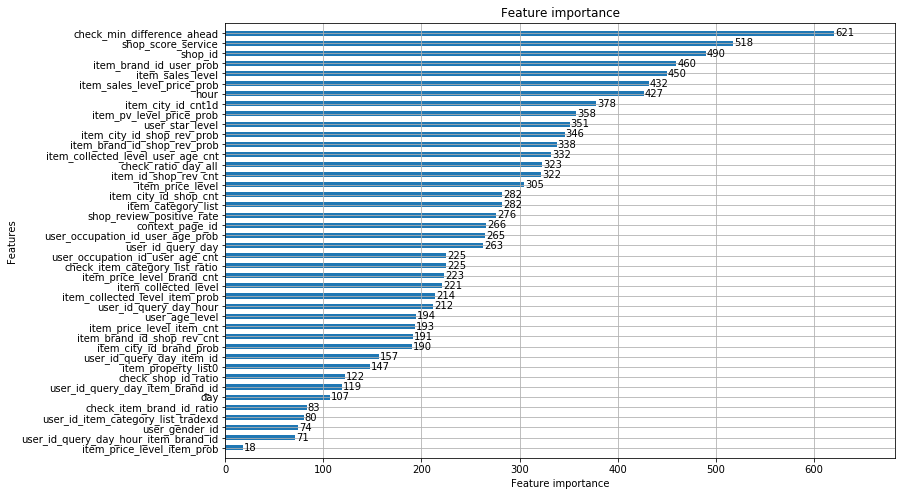

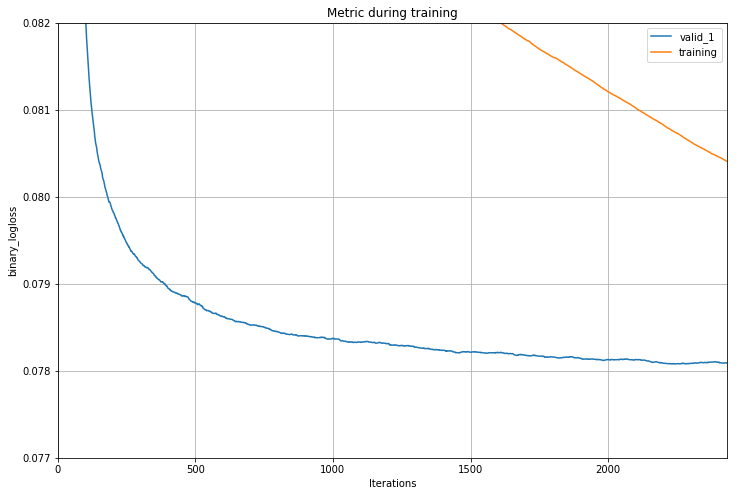

In [6]:
label = 'is_trade'
start_features =['item_city_id_brand_prob','item_price_level_brand_cnt','item_brand_id_user_prob',
                 'check_min_difference_ahead',
                 'item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'item_price_level_item_cnt', 'item_price_level_item_prob', 
                'user_id_item_category_list_tradexd','item_brand_id_shop_rev_cnt','item_brand_id_shop_rev_prob',
                 'user_occupation_id_user_age_cnt',
                ]
clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,n_estimators=20000,max_depth=3,learning_rate = 0.05, n_jobs=8)
clf = run(start_features, label, df2, clf, True)
lgbm.plot_importance(clf,figsize=(12,8),height=0.5)
plt.show()
lgbm.plot_metric(clf,figsize=(12,8),ylim=(0.077,0.082))
plt.show()

[1]	training's binary_logloss: 0.648015	valid_1's binary_logloss: 0.647877
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_logloss: 0.607184	valid_1's binary_logloss: 0.606907
[3]	training's binary_logloss: 0.570081	valid_1's binary_logloss: 0.569654
[4]	training's binary_logloss: 0.536235	valid_1's binary_logloss: 0.535675
[5]	training's binary_logloss: 0.50526	valid_1's binary_logloss: 0.504544
[6]	training's binary_logloss: 0.47683	valid_1's binary_logloss: 0.475978
[7]	training's binary_logloss: 0.450669	valid_1's binary_logloss: 0.44968
[8]	training's binary_logloss: 0.42654	valid_1's binary_logloss: 0.425424
[9]	training's binary_logloss: 0.404241	valid_1's binary_logloss: 0.40299
[10]	training's binary_logloss: 0.383598	valid_1's binary_logloss: 0.382212
[11]	training's binary_logloss: 0.364456	valid_1's binary_logloss: 0.362947
[12]	training's binary_logloss: 0.34668	valid_1's binary_logloss: 0.345036
[13]	training's binary_logloss: 0.330152

[111]	training's binary_logloss: 0.0889239	valid_1's binary_logloss: 0.0815598
[112]	training's binary_logloss: 0.0888756	valid_1's binary_logloss: 0.0815055
[113]	training's binary_logloss: 0.0888355	valid_1's binary_logloss: 0.0814593
[114]	training's binary_logloss: 0.0887939	valid_1's binary_logloss: 0.0814247
[115]	training's binary_logloss: 0.0887533	valid_1's binary_logloss: 0.0813805
[116]	training's binary_logloss: 0.0887102	valid_1's binary_logloss: 0.0813355
[117]	training's binary_logloss: 0.0886732	valid_1's binary_logloss: 0.0812951
[118]	training's binary_logloss: 0.0886381	valid_1's binary_logloss: 0.081259
[119]	training's binary_logloss: 0.0885901	valid_1's binary_logloss: 0.0812164
[120]	training's binary_logloss: 0.0885499	valid_1's binary_logloss: 0.0811768
[121]	training's binary_logloss: 0.088511	valid_1's binary_logloss: 0.0811369
[122]	training's binary_logloss: 0.0884699	valid_1's binary_logloss: 0.0811003
[123]	training's binary_logloss: 0.088436	valid_1's bi

[216]	training's binary_logloss: 0.0867124	valid_1's binary_logloss: 0.0797491
[217]	training's binary_logloss: 0.0866982	valid_1's binary_logloss: 0.0797338
[218]	training's binary_logloss: 0.0866886	valid_1's binary_logloss: 0.0797249
[219]	training's binary_logloss: 0.0866792	valid_1's binary_logloss: 0.079723
[220]	training's binary_logloss: 0.0866666	valid_1's binary_logloss: 0.0797135
[221]	training's binary_logloss: 0.0866564	valid_1's binary_logloss: 0.079699
[222]	training's binary_logloss: 0.0866468	valid_1's binary_logloss: 0.0796938
[223]	training's binary_logloss: 0.086633	valid_1's binary_logloss: 0.0796856
[224]	training's binary_logloss: 0.0866184	valid_1's binary_logloss: 0.0796691
[225]	training's binary_logloss: 0.086607	valid_1's binary_logloss: 0.0796657
[226]	training's binary_logloss: 0.0865975	valid_1's binary_logloss: 0.0796617
[227]	training's binary_logloss: 0.0865886	valid_1's binary_logloss: 0.079662
[228]	training's binary_logloss: 0.0865776	valid_1's bina

[326]	training's binary_logloss: 0.0857955	valid_1's binary_logloss: 0.0792106
[327]	training's binary_logloss: 0.0857906	valid_1's binary_logloss: 0.0792076
[328]	training's binary_logloss: 0.0857844	valid_1's binary_logloss: 0.0792038
[329]	training's binary_logloss: 0.0857776	valid_1's binary_logloss: 0.0791991
[330]	training's binary_logloss: 0.085772	valid_1's binary_logloss: 0.0791982
[331]	training's binary_logloss: 0.085766	valid_1's binary_logloss: 0.0792006
[332]	training's binary_logloss: 0.0857603	valid_1's binary_logloss: 0.0791981
[333]	training's binary_logloss: 0.085756	valid_1's binary_logloss: 0.0791969
[334]	training's binary_logloss: 0.0857506	valid_1's binary_logloss: 0.0791974
[335]	training's binary_logloss: 0.0857416	valid_1's binary_logloss: 0.0791899
[336]	training's binary_logloss: 0.0857353	valid_1's binary_logloss: 0.0791891
[337]	training's binary_logloss: 0.0857255	valid_1's binary_logloss: 0.0791807
[338]	training's binary_logloss: 0.0857193	valid_1's bi

[433]	training's binary_logloss: 0.0852293	valid_1's binary_logloss: 0.0789546
[434]	training's binary_logloss: 0.0852239	valid_1's binary_logloss: 0.0789475
[435]	training's binary_logloss: 0.0852201	valid_1's binary_logloss: 0.0789483
[436]	training's binary_logloss: 0.0852146	valid_1's binary_logloss: 0.078945
[437]	training's binary_logloss: 0.0852096	valid_1's binary_logloss: 0.0789422
[438]	training's binary_logloss: 0.085204	valid_1's binary_logloss: 0.0789388
[439]	training's binary_logloss: 0.0851984	valid_1's binary_logloss: 0.0789369
[440]	training's binary_logloss: 0.0851925	valid_1's binary_logloss: 0.0789344
[441]	training's binary_logloss: 0.0851871	valid_1's binary_logloss: 0.0789367
[442]	training's binary_logloss: 0.0851826	valid_1's binary_logloss: 0.0789362
[443]	training's binary_logloss: 0.0851786	valid_1's binary_logloss: 0.0789349
[444]	training's binary_logloss: 0.0851747	valid_1's binary_logloss: 0.0789363
[445]	training's binary_logloss: 0.0851718	valid_1's b

[541]	training's binary_logloss: 0.0847711	valid_1's binary_logloss: 0.0787406
[542]	training's binary_logloss: 0.0847649	valid_1's binary_logloss: 0.0787396
[543]	training's binary_logloss: 0.0847608	valid_1's binary_logloss: 0.0787412
[544]	training's binary_logloss: 0.084757	valid_1's binary_logloss: 0.0787399
[545]	training's binary_logloss: 0.0847542	valid_1's binary_logloss: 0.0787391
[546]	training's binary_logloss: 0.0847516	valid_1's binary_logloss: 0.07874
[547]	training's binary_logloss: 0.084747	valid_1's binary_logloss: 0.078738
[548]	training's binary_logloss: 0.0847424	valid_1's binary_logloss: 0.078735
[549]	training's binary_logloss: 0.0847391	valid_1's binary_logloss: 0.0787307
[550]	training's binary_logloss: 0.0847349	valid_1's binary_logloss: 0.0787319
[551]	training's binary_logloss: 0.0847319	valid_1's binary_logloss: 0.0787337
[552]	training's binary_logloss: 0.0847286	valid_1's binary_logloss: 0.0787326
[553]	training's binary_logloss: 0.0847237	valid_1's binar

[653]	training's binary_logloss: 0.0843698	valid_1's binary_logloss: 0.0786287
[654]	training's binary_logloss: 0.0843674	valid_1's binary_logloss: 0.0786265
[655]	training's binary_logloss: 0.0843627	valid_1's binary_logloss: 0.0786223
[656]	training's binary_logloss: 0.0843585	valid_1's binary_logloss: 0.0786199
[657]	training's binary_logloss: 0.084355	valid_1's binary_logloss: 0.078621
[658]	training's binary_logloss: 0.0843502	valid_1's binary_logloss: 0.0786193
[659]	training's binary_logloss: 0.0843468	valid_1's binary_logloss: 0.0786181
[660]	training's binary_logloss: 0.08434	valid_1's binary_logloss: 0.0786181
[661]	training's binary_logloss: 0.0843367	valid_1's binary_logloss: 0.0786115
[662]	training's binary_logloss: 0.0843322	valid_1's binary_logloss: 0.0786118
[663]	training's binary_logloss: 0.0843302	valid_1's binary_logloss: 0.0786093
[664]	training's binary_logloss: 0.0843284	valid_1's binary_logloss: 0.0786088
[665]	training's binary_logloss: 0.0843244	valid_1's bin

[764]	training's binary_logloss: 0.0840144	valid_1's binary_logloss: 0.07854
[765]	training's binary_logloss: 0.0840117	valid_1's binary_logloss: 0.0785404
[766]	training's binary_logloss: 0.0840095	valid_1's binary_logloss: 0.0785398
[767]	training's binary_logloss: 0.084006	valid_1's binary_logloss: 0.078538
[768]	training's binary_logloss: 0.084004	valid_1's binary_logloss: 0.0785389
[769]	training's binary_logloss: 0.084001	valid_1's binary_logloss: 0.0785377
[770]	training's binary_logloss: 0.0839968	valid_1's binary_logloss: 0.0785378
[771]	training's binary_logloss: 0.0839935	valid_1's binary_logloss: 0.0785402
[772]	training's binary_logloss: 0.0839897	valid_1's binary_logloss: 0.0785382
[773]	training's binary_logloss: 0.083988	valid_1's binary_logloss: 0.07854
[774]	training's binary_logloss: 0.0839855	valid_1's binary_logloss: 0.0785423
[775]	training's binary_logloss: 0.0839816	valid_1's binary_logloss: 0.0785426
[776]	training's binary_logloss: 0.0839796	valid_1's binary_l

[876]	training's binary_logloss: 0.0836916	valid_1's binary_logloss: 0.078482
[877]	training's binary_logloss: 0.0836899	valid_1's binary_logloss: 0.0784827
[878]	training's binary_logloss: 0.083687	valid_1's binary_logloss: 0.0784829
[879]	training's binary_logloss: 0.0836831	valid_1's binary_logloss: 0.078483
[880]	training's binary_logloss: 0.0836815	valid_1's binary_logloss: 0.0784828
[881]	training's binary_logloss: 0.0836802	valid_1's binary_logloss: 0.078483
[882]	training's binary_logloss: 0.0836771	valid_1's binary_logloss: 0.0784819
[883]	training's binary_logloss: 0.0836752	valid_1's binary_logloss: 0.0784836
[884]	training's binary_logloss: 0.0836727	valid_1's binary_logloss: 0.0784834
[885]	training's binary_logloss: 0.0836697	valid_1's binary_logloss: 0.0784812
[886]	training's binary_logloss: 0.083666	valid_1's binary_logloss: 0.0784818
[887]	training's binary_logloss: 0.0836624	valid_1's binary_logloss: 0.0784811
[888]	training's binary_logloss: 0.0836606	valid_1's bina

[983]	training's binary_logloss: 0.0834012	valid_1's binary_logloss: 0.0784004
[984]	training's binary_logloss: 0.0833975	valid_1's binary_logloss: 0.0783929
[985]	training's binary_logloss: 0.083396	valid_1's binary_logloss: 0.0783926
[986]	training's binary_logloss: 0.0833934	valid_1's binary_logloss: 0.0783898
[987]	training's binary_logloss: 0.0833919	valid_1's binary_logloss: 0.0783877
[988]	training's binary_logloss: 0.0833887	valid_1's binary_logloss: 0.0783848
[989]	training's binary_logloss: 0.0833861	valid_1's binary_logloss: 0.0783842
[990]	training's binary_logloss: 0.0833834	valid_1's binary_logloss: 0.0783832
[991]	training's binary_logloss: 0.0833821	valid_1's binary_logloss: 0.0783817
[992]	training's binary_logloss: 0.0833793	valid_1's binary_logloss: 0.0783816
[993]	training's binary_logloss: 0.0833751	valid_1's binary_logloss: 0.0783805
[994]	training's binary_logloss: 0.0833723	valid_1's binary_logloss: 0.0783795
[995]	training's binary_logloss: 0.0833703	valid_1's 

[1089]	training's binary_logloss: 0.083127	valid_1's binary_logloss: 0.0783452
[1090]	training's binary_logloss: 0.0831247	valid_1's binary_logloss: 0.0783451
[1091]	training's binary_logloss: 0.0831221	valid_1's binary_logloss: 0.078346
[1092]	training's binary_logloss: 0.0831176	valid_1's binary_logloss: 0.0783449
[1093]	training's binary_logloss: 0.0831144	valid_1's binary_logloss: 0.0783455
[1094]	training's binary_logloss: 0.0831097	valid_1's binary_logloss: 0.0783451
[1095]	training's binary_logloss: 0.0831061	valid_1's binary_logloss: 0.0783459
[1096]	training's binary_logloss: 0.0831039	valid_1's binary_logloss: 0.0783464
[1097]	training's binary_logloss: 0.0831029	valid_1's binary_logloss: 0.0783466
[1098]	training's binary_logloss: 0.0831003	valid_1's binary_logloss: 0.0783471
[1099]	training's binary_logloss: 0.083097	valid_1's binary_logloss: 0.0783474
[1100]	training's binary_logloss: 0.0830943	valid_1's binary_logloss: 0.0783468
[1101]	training's binary_logloss: 0.0830916

[1192]	training's binary_logloss: 0.0828717	valid_1's binary_logloss: 0.0783152
[1193]	training's binary_logloss: 0.0828695	valid_1's binary_logloss: 0.0783135
[1194]	training's binary_logloss: 0.0828666	valid_1's binary_logloss: 0.0783124
[1195]	training's binary_logloss: 0.0828645	valid_1's binary_logloss: 0.0783135
[1196]	training's binary_logloss: 0.0828618	valid_1's binary_logloss: 0.0783148
[1197]	training's binary_logloss: 0.0828593	valid_1's binary_logloss: 0.0783163
[1198]	training's binary_logloss: 0.0828569	valid_1's binary_logloss: 0.0783149
[1199]	training's binary_logloss: 0.0828546	valid_1's binary_logloss: 0.0783148
[1200]	training's binary_logloss: 0.0828528	valid_1's binary_logloss: 0.0783164
[1201]	training's binary_logloss: 0.0828515	valid_1's binary_logloss: 0.0783164
[1202]	training's binary_logloss: 0.0828485	valid_1's binary_logloss: 0.0783123
[1203]	training's binary_logloss: 0.0828456	valid_1's binary_logloss: 0.0783109
[1204]	training's binary_logloss: 0.0828

[1295]	training's binary_logloss: 0.0826385	valid_1's binary_logloss: 0.0782807
[1296]	training's binary_logloss: 0.082636	valid_1's binary_logloss: 0.0782794
[1297]	training's binary_logloss: 0.0826323	valid_1's binary_logloss: 0.0782808
[1298]	training's binary_logloss: 0.0826296	valid_1's binary_logloss: 0.0782742
[1299]	training's binary_logloss: 0.0826263	valid_1's binary_logloss: 0.078276
[1300]	training's binary_logloss: 0.0826245	valid_1's binary_logloss: 0.0782781
[1301]	training's binary_logloss: 0.0826207	valid_1's binary_logloss: 0.0782781
[1302]	training's binary_logloss: 0.0826187	valid_1's binary_logloss: 0.0782781
[1303]	training's binary_logloss: 0.0826172	valid_1's binary_logloss: 0.078279
[1304]	training's binary_logloss: 0.0826137	valid_1's binary_logloss: 0.078281
[1305]	training's binary_logloss: 0.0826073	valid_1's binary_logloss: 0.0782825
[1306]	training's binary_logloss: 0.0826057	valid_1's binary_logloss: 0.078283
[1307]	training's binary_logloss: 0.0826037	v

[1401]	training's binary_logloss: 0.0823837	valid_1's binary_logloss: 0.0782692
[1402]	training's binary_logloss: 0.0823832	valid_1's binary_logloss: 0.078269
[1403]	training's binary_logloss: 0.0823813	valid_1's binary_logloss: 0.0782698
[1404]	training's binary_logloss: 0.0823783	valid_1's binary_logloss: 0.0782728
[1405]	training's binary_logloss: 0.0823754	valid_1's binary_logloss: 0.0782711
[1406]	training's binary_logloss: 0.0823733	valid_1's binary_logloss: 0.0782691
[1407]	training's binary_logloss: 0.0823711	valid_1's binary_logloss: 0.078272
[1408]	training's binary_logloss: 0.0823679	valid_1's binary_logloss: 0.0782728
[1409]	training's binary_logloss: 0.0823656	valid_1's binary_logloss: 0.0782722
[1410]	training's binary_logloss: 0.0823636	valid_1's binary_logloss: 0.0782716
[1411]	training's binary_logloss: 0.0823616	valid_1's binary_logloss: 0.0782715
[1412]	training's binary_logloss: 0.0823588	valid_1's binary_logloss: 0.0782687
[1413]	training's binary_logloss: 0.082356

[1508]	training's binary_logloss: 0.0821455	valid_1's binary_logloss: 0.0782388
[1509]	training's binary_logloss: 0.0821435	valid_1's binary_logloss: 0.0782374
[1510]	training's binary_logloss: 0.0821406	valid_1's binary_logloss: 0.0782364
[1511]	training's binary_logloss: 0.0821374	valid_1's binary_logloss: 0.0782383
[1512]	training's binary_logloss: 0.0821341	valid_1's binary_logloss: 0.078238
[1513]	training's binary_logloss: 0.0821312	valid_1's binary_logloss: 0.07824
[1514]	training's binary_logloss: 0.0821288	valid_1's binary_logloss: 0.078241
[1515]	training's binary_logloss: 0.0821265	valid_1's binary_logloss: 0.0782398
[1516]	training's binary_logloss: 0.0821239	valid_1's binary_logloss: 0.0782428
[1517]	training's binary_logloss: 0.0821208	valid_1's binary_logloss: 0.0782437
[1518]	training's binary_logloss: 0.082116	valid_1's binary_logloss: 0.0782416
[1519]	training's binary_logloss: 0.0821136	valid_1's binary_logloss: 0.0782396
[1520]	training's binary_logloss: 0.0821111	v

[1612]	training's binary_logloss: 0.0819257	valid_1's binary_logloss: 0.0782282
[1613]	training's binary_logloss: 0.0819237	valid_1's binary_logloss: 0.078226
[1614]	training's binary_logloss: 0.081922	valid_1's binary_logloss: 0.0782263
[1615]	training's binary_logloss: 0.0819194	valid_1's binary_logloss: 0.0782254
[1616]	training's binary_logloss: 0.0819175	valid_1's binary_logloss: 0.078223
[1617]	training's binary_logloss: 0.0819162	valid_1's binary_logloss: 0.0782233
[1618]	training's binary_logloss: 0.0819146	valid_1's binary_logloss: 0.0782249
[1619]	training's binary_logloss: 0.0819124	valid_1's binary_logloss: 0.0782273
[1620]	training's binary_logloss: 0.0819099	valid_1's binary_logloss: 0.0782281
[1621]	training's binary_logloss: 0.0819073	valid_1's binary_logloss: 0.0782272
[1622]	training's binary_logloss: 0.0819046	valid_1's binary_logloss: 0.0782274
[1623]	training's binary_logloss: 0.0819022	valid_1's binary_logloss: 0.0782267
[1624]	training's binary_logloss: 0.0819002

[1719]	training's binary_logloss: 0.0816999	valid_1's binary_logloss: 0.0782165
[1720]	training's binary_logloss: 0.0816982	valid_1's binary_logloss: 0.0782164
[1721]	training's binary_logloss: 0.0816957	valid_1's binary_logloss: 0.0782166
[1722]	training's binary_logloss: 0.0816946	valid_1's binary_logloss: 0.0782159
[1723]	training's binary_logloss: 0.0816934	valid_1's binary_logloss: 0.0782154
[1724]	training's binary_logloss: 0.0816913	valid_1's binary_logloss: 0.0782157
[1725]	training's binary_logloss: 0.0816889	valid_1's binary_logloss: 0.0782168
[1726]	training's binary_logloss: 0.0816863	valid_1's binary_logloss: 0.0782166
[1727]	training's binary_logloss: 0.0816841	valid_1's binary_logloss: 0.078219
[1728]	training's binary_logloss: 0.0816811	valid_1's binary_logloss: 0.0782189
[1729]	training's binary_logloss: 0.0816775	valid_1's binary_logloss: 0.0782196
[1730]	training's binary_logloss: 0.0816749	valid_1's binary_logloss: 0.0782194
[1731]	training's binary_logloss: 0.08167

[1827]	training's binary_logloss: 0.0814864	valid_1's binary_logloss: 0.0782064
[1828]	training's binary_logloss: 0.0814839	valid_1's binary_logloss: 0.0782071
[1829]	training's binary_logloss: 0.0814807	valid_1's binary_logloss: 0.0782061
[1830]	training's binary_logloss: 0.0814792	valid_1's binary_logloss: 0.0782076
[1831]	training's binary_logloss: 0.0814775	valid_1's binary_logloss: 0.0782106
[1832]	training's binary_logloss: 0.081472	valid_1's binary_logloss: 0.0782094
[1833]	training's binary_logloss: 0.0814693	valid_1's binary_logloss: 0.0782098
[1834]	training's binary_logloss: 0.0814667	valid_1's binary_logloss: 0.0782071
[1835]	training's binary_logloss: 0.0814649	valid_1's binary_logloss: 0.0782089
[1836]	training's binary_logloss: 0.0814625	valid_1's binary_logloss: 0.078208
[1837]	training's binary_logloss: 0.0814604	valid_1's binary_logloss: 0.0782072
[1838]	training's binary_logloss: 0.0814584	valid_1's binary_logloss: 0.0782078
[1839]	training's binary_logloss: 0.081454

[1932]	training's binary_logloss: 0.0812722	valid_1's binary_logloss: 0.0781839
[1933]	training's binary_logloss: 0.0812702	valid_1's binary_logloss: 0.0781811
[1934]	training's binary_logloss: 0.0812685	valid_1's binary_logloss: 0.0781797
[1935]	training's binary_logloss: 0.0812668	valid_1's binary_logloss: 0.0781803
[1936]	training's binary_logloss: 0.0812649	valid_1's binary_logloss: 0.0781806
[1937]	training's binary_logloss: 0.0812626	valid_1's binary_logloss: 0.0781824
[1938]	training's binary_logloss: 0.0812605	valid_1's binary_logloss: 0.078181
[1939]	training's binary_logloss: 0.0812587	valid_1's binary_logloss: 0.0781793
[1940]	training's binary_logloss: 0.0812568	valid_1's binary_logloss: 0.0781798
[1941]	training's binary_logloss: 0.0812548	valid_1's binary_logloss: 0.0781801
[1942]	training's binary_logloss: 0.081253	valid_1's binary_logloss: 0.0781799
[1943]	training's binary_logloss: 0.0812498	valid_1's binary_logloss: 0.0781811
[1944]	training's binary_logloss: 0.081247

[2037]	training's binary_logloss: 0.0810496	valid_1's binary_logloss: 0.0781635
[2038]	training's binary_logloss: 0.0810476	valid_1's binary_logloss: 0.0781652
[2039]	training's binary_logloss: 0.0810456	valid_1's binary_logloss: 0.0781647
[2040]	training's binary_logloss: 0.0810443	valid_1's binary_logloss: 0.0781647
[2041]	training's binary_logloss: 0.081043	valid_1's binary_logloss: 0.0781651
[2042]	training's binary_logloss: 0.0810417	valid_1's binary_logloss: 0.078166
[2043]	training's binary_logloss: 0.0810398	valid_1's binary_logloss: 0.0781665
[2044]	training's binary_logloss: 0.0810378	valid_1's binary_logloss: 0.0781672
[2045]	training's binary_logloss: 0.0810362	valid_1's binary_logloss: 0.0781676
[2046]	training's binary_logloss: 0.0810339	valid_1's binary_logloss: 0.0781665
[2047]	training's binary_logloss: 0.0810313	valid_1's binary_logloss: 0.0781664
[2048]	training's binary_logloss: 0.0810289	valid_1's binary_logloss: 0.0781679
[2049]	training's binary_logloss: 0.081027

[2145]	training's binary_logloss: 0.0808363	valid_1's binary_logloss: 0.0781486
[2146]	training's binary_logloss: 0.0808341	valid_1's binary_logloss: 0.0781496
[2147]	training's binary_logloss: 0.080832	valid_1's binary_logloss: 0.0781515
[2148]	training's binary_logloss: 0.0808299	valid_1's binary_logloss: 0.0781547
[2149]	training's binary_logloss: 0.0808277	valid_1's binary_logloss: 0.078154
[2150]	training's binary_logloss: 0.0808257	valid_1's binary_logloss: 0.0781542
[2151]	training's binary_logloss: 0.080823	valid_1's binary_logloss: 0.0781557
[2152]	training's binary_logloss: 0.0808204	valid_1's binary_logloss: 0.0781521
[2153]	training's binary_logloss: 0.0808176	valid_1's binary_logloss: 0.0781524
[2154]	training's binary_logloss: 0.0808158	valid_1's binary_logloss: 0.0781538
[2155]	training's binary_logloss: 0.0808132	valid_1's binary_logloss: 0.0781526
[2156]	training's binary_logloss: 0.0808117	valid_1's binary_logloss: 0.078153
[2157]	training's binary_logloss: 0.0808095	

[2253]	training's binary_logloss: 0.0806365	valid_1's binary_logloss: 0.0781283
[2254]	training's binary_logloss: 0.0806354	valid_1's binary_logloss: 0.0781304
[2255]	training's binary_logloss: 0.080633	valid_1's binary_logloss: 0.0781287
[2256]	training's binary_logloss: 0.0806314	valid_1's binary_logloss: 0.078128
[2257]	training's binary_logloss: 0.0806296	valid_1's binary_logloss: 0.0781298
[2258]	training's binary_logloss: 0.0806272	valid_1's binary_logloss: 0.0781308
[2259]	training's binary_logloss: 0.0806234	valid_1's binary_logloss: 0.0781309
[2260]	training's binary_logloss: 0.0806212	valid_1's binary_logloss: 0.0781314
[2261]	training's binary_logloss: 0.0806194	valid_1's binary_logloss: 0.0781296
[2262]	training's binary_logloss: 0.0806181	valid_1's binary_logloss: 0.0781295
[2263]	training's binary_logloss: 0.0806163	valid_1's binary_logloss: 0.0781295
[2264]	training's binary_logloss: 0.0806146	valid_1's binary_logloss: 0.078131
[2265]	training's binary_logloss: 0.0806133

[2360]	training's binary_logloss: 0.0804278	valid_1's binary_logloss: 0.0781171
[2361]	training's binary_logloss: 0.0804249	valid_1's binary_logloss: 0.0781162
[2362]	training's binary_logloss: 0.0804228	valid_1's binary_logloss: 0.0781153
[2363]	training's binary_logloss: 0.0804209	valid_1's binary_logloss: 0.0781165
[2364]	training's binary_logloss: 0.080419	valid_1's binary_logloss: 0.0781125
[2365]	training's binary_logloss: 0.0804172	valid_1's binary_logloss: 0.0781123
[2366]	training's binary_logloss: 0.0804147	valid_1's binary_logloss: 0.0781123
[2367]	training's binary_logloss: 0.0804126	valid_1's binary_logloss: 0.0781104
[2368]	training's binary_logloss: 0.080411	valid_1's binary_logloss: 0.0781114
[2369]	training's binary_logloss: 0.0804097	valid_1's binary_logloss: 0.0781101
[2370]	training's binary_logloss: 0.0804067	valid_1's binary_logloss: 0.0781079
[2371]	training's binary_logloss: 0.0804044	valid_1's binary_logloss: 0.0781072
[2372]	training's binary_logloss: 0.080402

[2470]	training's binary_logloss: 0.080221	valid_1's binary_logloss: 0.0781152
[2471]	training's binary_logloss: 0.0802195	valid_1's binary_logloss: 0.078116
[2472]	training's binary_logloss: 0.0802175	valid_1's binary_logloss: 0.0781159
[2473]	training's binary_logloss: 0.0802156	valid_1's binary_logloss: 0.0781173
[2474]	training's binary_logloss: 0.0802137	valid_1's binary_logloss: 0.078115
[2475]	training's binary_logloss: 0.0802114	valid_1's binary_logloss: 0.0781151
[2476]	training's binary_logloss: 0.0802091	valid_1's binary_logloss: 0.0781164
[2477]	training's binary_logloss: 0.0802075	valid_1's binary_logloss: 0.0781167
[2478]	training's binary_logloss: 0.0802059	valid_1's binary_logloss: 0.0781151
[2479]	training's binary_logloss: 0.0802037	valid_1's binary_logloss: 0.0781142
[2480]	training's binary_logloss: 0.0802026	valid_1's binary_logloss: 0.0781147
[2481]	training's binary_logloss: 0.0802011	valid_1's binary_logloss: 0.0781143
[2482]	training's binary_logloss: 0.0801992

[2576]	training's binary_logloss: 0.0800343	valid_1's binary_logloss: 0.0781049
[2577]	training's binary_logloss: 0.080032	valid_1's binary_logloss: 0.0781072
[2578]	training's binary_logloss: 0.0800295	valid_1's binary_logloss: 0.0781043
[2579]	training's binary_logloss: 0.0800281	valid_1's binary_logloss: 0.0781035
[2580]	training's binary_logloss: 0.0800261	valid_1's binary_logloss: 0.0781057
[2581]	training's binary_logloss: 0.0800246	valid_1's binary_logloss: 0.0781083
[2582]	training's binary_logloss: 0.0800227	valid_1's binary_logloss: 0.0781067
[2583]	training's binary_logloss: 0.0800207	valid_1's binary_logloss: 0.0781075
[2584]	training's binary_logloss: 0.0800185	valid_1's binary_logloss: 0.0781089
[2585]	training's binary_logloss: 0.0800173	valid_1's binary_logloss: 0.0781084
[2586]	training's binary_logloss: 0.0800148	valid_1's binary_logloss: 0.0781084
[2587]	training's binary_logloss: 0.0800125	valid_1's binary_logloss: 0.0781086
[2588]	training's binary_logloss: 0.08001

[2681]	training's binary_logloss: 0.0798508	valid_1's binary_logloss: 0.078102
[2682]	training's binary_logloss: 0.079849	valid_1's binary_logloss: 0.0781027
[2683]	training's binary_logloss: 0.0798475	valid_1's binary_logloss: 0.078102
[2684]	training's binary_logloss: 0.0798458	valid_1's binary_logloss: 0.0781032
[2685]	training's binary_logloss: 0.0798442	valid_1's binary_logloss: 0.0781025
[2686]	training's binary_logloss: 0.0798424	valid_1's binary_logloss: 0.0781043
[2687]	training's binary_logloss: 0.07984	valid_1's binary_logloss: 0.0781036
[2688]	training's binary_logloss: 0.0798378	valid_1's binary_logloss: 0.078105
[2689]	training's binary_logloss: 0.0798359	valid_1's binary_logloss: 0.0781043
[2690]	training's binary_logloss: 0.0798344	valid_1's binary_logloss: 0.0781041
[2691]	training's binary_logloss: 0.0798323	valid_1's binary_logloss: 0.0781052
[2692]	training's binary_logloss: 0.0798302	valid_1's binary_logloss: 0.078106
[2693]	training's binary_logloss: 0.0798278	val

[2785]	training's binary_logloss: 0.0796778	valid_1's binary_logloss: 0.07811
[2786]	training's binary_logloss: 0.0796756	valid_1's binary_logloss: 0.078109
[2787]	training's binary_logloss: 0.0796736	valid_1's binary_logloss: 0.0781083
[2788]	training's binary_logloss: 0.0796722	valid_1's binary_logloss: 0.0781088
[2789]	training's binary_logloss: 0.0796705	valid_1's binary_logloss: 0.0781058
[2790]	training's binary_logloss: 0.0796688	valid_1's binary_logloss: 0.0781064
[2791]	training's binary_logloss: 0.0796676	valid_1's binary_logloss: 0.0781053
[2792]	training's binary_logloss: 0.0796651	valid_1's binary_logloss: 0.0781046
[2793]	training's binary_logloss: 0.0796639	valid_1's binary_logloss: 0.0781053
[2794]	training's binary_logloss: 0.0796623	valid_1's binary_logloss: 0.0781045
[2795]	training's binary_logloss: 0.0796606	valid_1's binary_logloss: 0.0781031
[2796]	training's binary_logloss: 0.0796601	valid_1's binary_logloss: 0.0781026
[2797]	training's binary_logloss: 0.0796582

[2895]	training's binary_logloss: 0.0795113	valid_1's binary_logloss: 0.0780928
[2896]	training's binary_logloss: 0.0795091	valid_1's binary_logloss: 0.0780944
[2897]	training's binary_logloss: 0.0795073	valid_1's binary_logloss: 0.0780957
[2898]	training's binary_logloss: 0.0795056	valid_1's binary_logloss: 0.0780953
[2899]	training's binary_logloss: 0.0795038	valid_1's binary_logloss: 0.0780947
[2900]	training's binary_logloss: 0.0795022	valid_1's binary_logloss: 0.0780942
[2901]	training's binary_logloss: 0.0795008	valid_1's binary_logloss: 0.0780942
[2902]	training's binary_logloss: 0.0794991	valid_1's binary_logloss: 0.0780951
[2903]	training's binary_logloss: 0.0794986	valid_1's binary_logloss: 0.078095
[2904]	training's binary_logloss: 0.0794969	valid_1's binary_logloss: 0.0780947
[2905]	training's binary_logloss: 0.079496	valid_1's binary_logloss: 0.0780958
[2906]	training's binary_logloss: 0.079494	valid_1's binary_logloss: 0.0780957
[2907]	training's binary_logloss: 0.0794926

[3004]	training's binary_logloss: 0.0793389	valid_1's binary_logloss: 0.0781014
[3005]	training's binary_logloss: 0.0793379	valid_1's binary_logloss: 0.0781019
[3006]	training's binary_logloss: 0.0793362	valid_1's binary_logloss: 0.078102
[3007]	training's binary_logloss: 0.0793349	valid_1's binary_logloss: 0.0781026
[3008]	training's binary_logloss: 0.0793333	valid_1's binary_logloss: 0.0781024
[3009]	training's binary_logloss: 0.0793319	valid_1's binary_logloss: 0.0781035
[3010]	training's binary_logloss: 0.0793305	valid_1's binary_logloss: 0.0781036
[3011]	training's binary_logloss: 0.0793293	valid_1's binary_logloss: 0.0781047
[3012]	training's binary_logloss: 0.0793274	valid_1's binary_logloss: 0.0781055
[3013]	training's binary_logloss: 0.0793257	valid_1's binary_logloss: 0.0781041
[3014]	training's binary_logloss: 0.0793251	valid_1's binary_logloss: 0.0781057
[3015]	training's binary_logloss: 0.0793245	valid_1's binary_logloss: 0.0781066
[3016]	training's binary_logloss: 0.07932

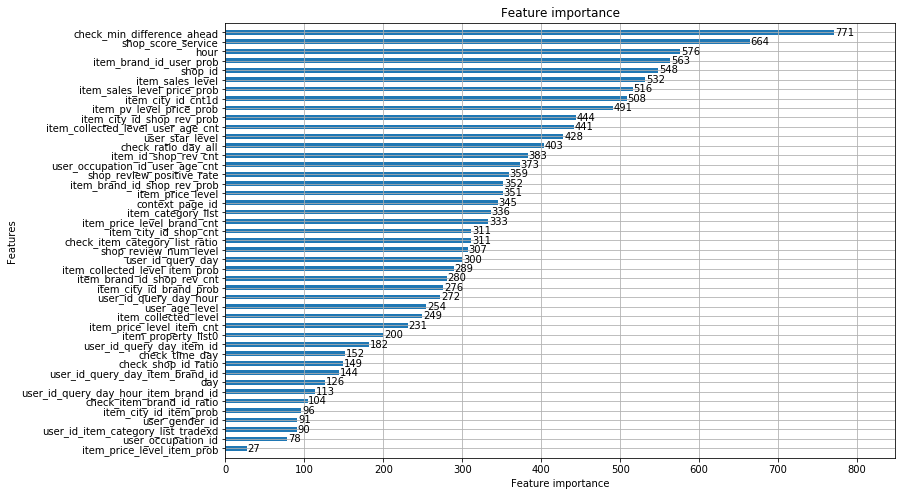

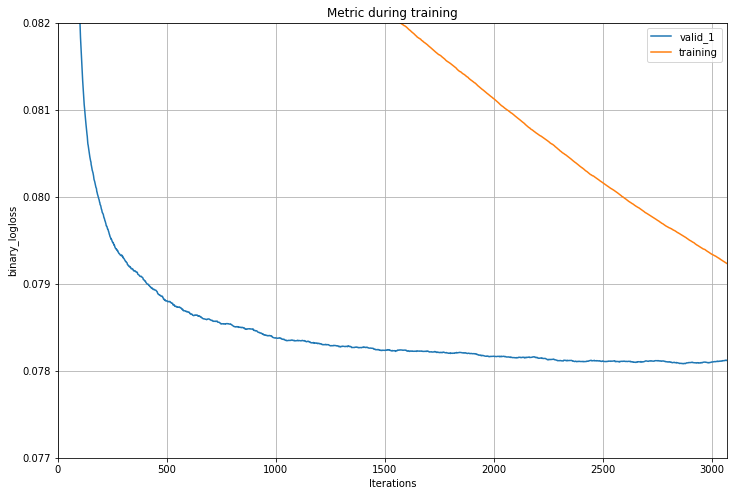

In [14]:
label = 'is_trade'
start_features =['item_city_id_item_prob','item_brand_id_shop_rev_prob', 'item_price_level_brand_cnt', 'user_occupation_id_user_age_cnt', 'item_city_id_brand_prob', 'item_brand_id_shop_rev_cnt', 'item_brand_id_user_prob', 'user_id_item_category_list_tradexd','check_min_difference_ahead','item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_page_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'check_time_day', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 
                 #'user_id_query_day_hour_map_item_pv_level',
                 'item_price_level_item_cnt','item_price_level_item_prob']
clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,n_estimators=20000,max_depth=3,learning_rate = 0.05, n_jobs=8)
clf = run(start_features, label, df2, clf, True)
lgbm.plot_importance(clf,figsize=(12,8),height=0.5)
plt.show()
lgbm.plot_metric(clf,figsize=(12,8),ylim=(0.077,0.082))
plt.show()

In [21]:
t1 = ['item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'item_price_level_item_cnt', 'item_price_level_item_prob', 'user_age_level_trade_meanxd', 'user_id_item_category_list_tradexd']
t2 = ['item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'item_price_level_item_cnt', 'item_price_level_item_prob', 'user_age_level_trade_meanxd', 'user_id_item_category_list_tradexd','user_occupation_id', 'user_id_query_day_hour_map_item_pv_level', 'check_time_day', 'shop_review_num_level']
t3 = ['item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_page_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'check_time_day', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'user_id_query_day_hour_map_item_pv_level','item_price_level_item_cnt','item_price_level_item_prob']
print(set(t2) - set(t1))
print(set(t2) - set(t3))
print(set(t3) - set(t1))

{'user_occupation_id', 'user_id_query_day_hour_map_item_pv_level', 'check_time_day', 'shop_review_num_level'}
{'user_age_level_trade_meanxd', 'user_id_item_category_list_tradexd'}
{'user_age_level_trade_meanxd', 'user_id_item_category_list_tradexd'}
{'user_occupation_id', 'user_id_query_day_hour_map_item_pv_level', 'check_time_day', 'shop_review_num_level'}


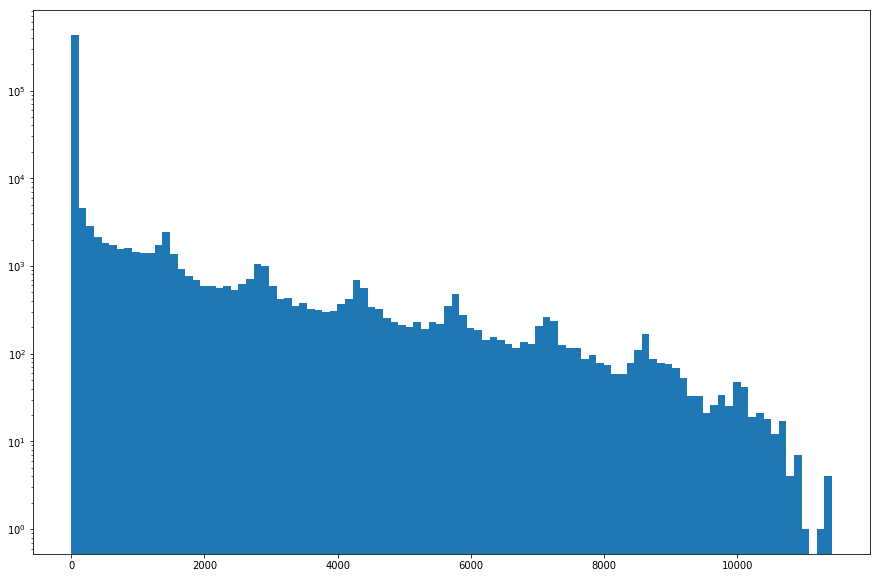

In [38]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
plt.hist(df2.check_min_difference_ahead,100)
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show()

In [25]:
df2.check_min_difference_ahead.max()

11420.0

In [28]:
df2.min_series_full.min()

0

In [ ]:
label = 'is_trade'
start_features = ['item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 
                 'user_id_shop_id_trade_meanxd', 
                 'user_age_level_trade_meanxd', 
                 #'predict_category_property0','item_property_list0','predict_category_property1','item_property_list1',
                 'user_id_item_category_list_tradexd', 'shop_star_level_user_prob', 'shop_id_user_prob']

clf = lgbm.LGBMClassifier(random_state=1, num_leaves = 6,
                          n_estimators=20000,max_depth=3,learning_rate = 0.05, 
                          n_jobs=30)
#0.07855
for i in df2.columns[:]:
    if ('cnt' in i):
        t = i.split('_')
        t = t[:-1]
        print(i)
        t1 = '_'.join(t)+'_cnt'
        t2 = '_'.join(t)+'_prob'
        try:
            clf = run(start_features + [t1,t2], label, df2, clf, False)
            print(clf.best_iteration_)
        except KeyError:
            pass

user_id_cnt1d
item_id_cnt1d
shop_id_cnt1d
item_city_id_cnt1d
item_brand_id_cnt1d
item_property_list0_cnt1d
item_category_list_cnt1d
user_id_cntxd
item_id_cntxd
shop_id_cntxd
item_city_id_cntxd
item_brand_id_cntxd
item_property_list0_cntxd
item_category_list_cntxd
user_id_cnt1h


In [13]:
lbgnode = (clf.apply(df2[start_features]) - 2.5)/2.5

In [14]:
a = LogisticRegression(n_jobs=-1, random_state=1, solver  = 'saga')
fm_model = xl.FMModel(task='binary', init=0.1, epoch=10, k=4, lr=0.1, 
                      reg_lambda=0.01, opt='sgd', metric='auc')

In [15]:
a.fit(lbgnode[df2.context_timestamp <= '2018-09-23 23:59:59'], df2[df2.context_timestamp <= '2018-09-23 23:59:59'].is_trade)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=1, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
log_loss(df2[df2.context_timestamp <= '2018-09-23 23:59:59'].is_trade, a.predict_proba(lbgnode[df2.context_timestamp <= '2018-09-23 23:59:59'])[:,1])

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


0.07949182247907448

In [19]:
log_loss(df2[df2.context_timestamp > '2018-09-23 23:59:59'].is_trade, a.predict_proba(lbgnode[df2.context_timestamp > '2018-09-23 23:59:59'])[:,1])

0.08295475918712836

In [19]:
lbgnode

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


array([[-0.6, -0.6, -0.6, ...,  1. ,  1. ,  1. ],
       [-0.6,  0.6, -0.6, ...,  1. ,  1. ,  1. ],
       [ 0.6, -0.2,  0.6, ...,  1. ,  1. ,  1. ],
       ...,
       [-0.6,  1. , -0.6, ...,  1. ,  1. ,  1. ],
       [-1. ,  1. , -1. , ...,  1. ,  1. ,  1. ],
       [ 0.2, -0.6,  0.2, ..., -1. ,  0.6, -0.6]])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [6]:
start_features =['item_category_list', 'item_price_level', 'item_sales_level', 'item_collected_level', 'user_gender_id', 'user_age_level', 'user_star_level', 'context_page_id', 'shop_review_positive_rate', 'shop_score_service', 'hour', 'day', 'user_id_query_day_hour', 'shop_id', 'user_id_query_day_item_brand_id', 'user_id_query_day_hour_item_brand_id', 'user_id_query_day', 'user_id_query_day_item_id', 'check_item_brand_id_ratio', 'check_shop_id_ratio', 'check_item_category_list_ratio', 'check_ratio_day_all', 'item_city_id_shop_cnt', 'item_city_id_shop_rev_prob', 'item_id_shop_rev_cnt', 'item_property_list0', 'item_pv_level_price_prob', 'item_collected_level_item_prob', 'item_sales_level_price_prob', 'item_city_id_cnt1d', 'item_collected_level_user_age_cnt', 'item_price_level_item_cnt', 'item_price_level_item_prob', 'user_id_shop_id_trade_meanxd', 'user_age_level_trade_meanxd', 'user_id_item_category_list_tradexd']
len(start_features)

36

In [48]:
for i in df2.columns:
    if ('predict' in i) or ('property' in i):
        print(i)

item_property_list
predict_category_property
len_item_property
item_property_list0
item_property_list1
item_property_list2
item_property_list3
item_property_list4
item_property_list5
item_property_list6
item_property_list7
item_property_list8
item_property_list9
len_predict_category_property
predict_category_property0
predict_category_property1
predict_category_property2
predict_category_property3
predict_category_property4
item_property_list0_cnt1d
item_property_list0_cntxd
item_property_list0_cnt1h
item_property_list0_cntxh


In [76]:
def sp(x):
    return x.split(";")

def sp2(x):
    return [i.split(':')[0] for i in x.split(";")]

In [77]:
tt = set([i for i in df2.item_property_list.apply(sp)][0])

In [78]:
tt2 = set([i for i in df2.predict_category_property.apply(sp2)][0])

In [81]:
df2[['item_property_list0','item_property_list1','item_property_list2','item_property_list3','item_property_list4']]

,item_property_list0,item_property_list1,item_property_list2,item_property_list3,item_property_list4
0,109,55,52,211,155
1,109,26,146,108,12
2,27,18,100,51,102
3,109,26,149,68,72
4,42,86,87,108,265
5,27,26,52,8,375
6,109,26,192,133,263
7,27,18,100,51,102
8,109,26,38,228,12
9,109,55,52,211,155


In [83]:
df2[['predict_category_property0','predict_category_property1','predict_category_property2','predict_category_property3','predict_category_property4']]

,predict_category_property0,predict_category_property1,predict_category_property2,predict_category_property3,predict_category_property4
0,1892,2618,9475,5423,0
1,2548,1886,4131,2678,1818
2,7715,10043,9226,3067,0
3,4942,4545,1985,1053,3560
4,2752,4641,9258,10348,0
5,1966,10543,2548,4238,116
6,7705,4641,0,0,0
7,7705,4641,0,0,0
8,2321,3226,10487,4238,0
9,2321,10236,4346,3068,0


In [94]:
tt2 = df2['predict_category_property'].map(lambda x: str(str(x).split(';')[1].split(':')[0]) if len(str(x).split(';')) > 1 else '')

In [95]:
np.unique(tt2)

array(['', '1010510648286206651', '1036082357054043890',
       '1050442525875593374', '1147074168968532252',
       '1156125343031872952', '1214375565347289759',
       '1265418482003436351', '1270200392831981176',
       '1298038284890876598', '1353756234974938268',
       '1364646816312275146', '1366644025518387445',
       '1367177154073382718', '1367421226574550486',
       '1414806584228710192', '1421900015824192217',
       '1433572652414468240', '14911707481673176', '1495388799908940789',
       '1506490748403667458', '1532161334071698699',
       '1545503375461931806', '156332117404375969', '1607935475310731343',
       '1636691591937407249', '1660865242526967073',
       '1690307069718831151', '1760164811125093110',
       '1771349742445680985', '1773757399237042247',
       '1811811930698375325', '1817305422096211121',
       '1851878448883958882', '1852495838110822601',
       '1852600517265062354', '1855683652748797990',
       '1881612762122593430', '1901185639865396111',

In [98]:
np.unique(df2.predict_category_property1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  54,  55,  56,  57,  58,  59,  61,  62,  63,  64,  65,  66,
        67,  69,  70,  71,  72,  73,  74,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 18

In [9]:
'shop_star_level_user_prob' in df2.columns

True

In [14]:
df2[pd.isnull(df2.user_id_item_category_list_tradexd)].shape

(429800, 474)